# **Import thư viện**

In [1]:
import numpy as np
from IPython import display
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import random
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from time import sleep
import plotly.graph_objects as go

# **Các hàm mục tiêu**

In [2]:
def Sphere(x):
    f = 0
    for i in x:
        f += i**2
    return f

In [3]:
def Michalewicz(x):
    m = 10
    f = 0
    for i, xi in enumerate(x):
        f += math.sin(xi) * math.sin(((i + 1) * xi**2) / math.pi)**(2 * m)
    return -f

In [4]:
def Rosenbrock(x):
    f = 0
    for i in range(len(x) - 1):
        f += (100*((x[i + 1] - x[i]**2)**2) + (1 -x[i])**2)
    return f

In [5]:
def Griewank(x):
    f1 = 0
    for i in x:
        f1 += (i*i)/4000
    f2 = 1
    for i in range(len(x)):
        f2 *= np.cos(x[i]/math.sqrt(i+1))
    return f1 - f2 + 1

In [6]:
def Ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    f1 = 0
    f2 = 0
    for i in range(len(x)):
        f1 += x[i] ** 2
        f2 += np.cos(c * x[i])
    p1 = -a * np.exp(-b * np.sqrt(f1 / len(x)))
    p2 = -np.exp(f2 / len(x))

    return p1 + p2 + a + np.exp(1)

# **Differential Evolution (DE)**

In [7]:
def DE(objective_function, dimension, bounds, F_scale, cross_prob, population_size, max_evaluations):
    lower_bounds, upper_bounds = np.asarray(bounds).T
    epsilon = 1e-8
    differences = np.fabs(lower_bounds - upper_bounds)
    population = lower_bounds + differences * np.random.rand(population_size, dimension)

    fitness_values = np.asarray([objective_function(individual) for individual in population])
    num_evaluations = population_size

    best_index = np.argmin(fitness_values)
    best_individual = population[best_index]

    results = []
    all_populations = []
    results.append((np.copy(best_individual), fitness_values[best_index], num_evaluations))
    all_populations.append(np.copy(population))

    while num_evaluations < max_evaluations:
        trial_population = np.zeros_like(population)
        for i in range(population_size):
            indexes = [idx for idx in range(population_size) if idx != i]
            a, b, c = population[np.random.choice(indexes, 3, replace=False)]
            mutant = np.clip(population[i] + F_scale * (b - c), lower_bounds, upper_bounds)
            cross_points = np.random.rand(dimension) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimension)] = True

            trial_population[i] = np.where(cross_points, mutant, population[i])

        trial_fitness_values = np.asarray([objective_function(individual) for individual in trial_population])
        num_evaluations += population_size

        for i in range(population_size):
            if trial_fitness_values[i] < fitness_values[i]:
                population[i] = trial_population[i]
                fitness_values[i] = trial_fitness_values[i]
                if trial_fitness_values[i] < fitness_values[best_index]:
                    best_individual = trial_population[i]
                    best_index = i

        results.append((np.copy(best_individual), fitness_values[best_index], num_evaluations))
        all_populations.append(np.copy(population))

        if fitness_values[best_index] < epsilon:
            break

    return results, all_populations, num_evaluations


# **Cross Entropy Method (CEM)**

In [8]:
def CEM(fobj, bounds, initial_sigma, elite_fraction, population_size, max_evaluations):
    lower_bound, upper_bound = np.asarray(bounds).T

    epsilon = 1e-8

    diff = np.fabs(lower_bound - upper_bound)

    mu = lower_bound + diff * np.random.rand(len(bounds))
    mu_fitness = fobj(mu)
    num_eval = 1

    results = []
    all_populations = []
    results.append((np.copy(mu), mu_fitness, num_eval))
    sigma = initial_sigma

    while num_eval < max_evaluations:
        num_elite = int(population_size * elite_fraction)
        samples = np.random.normal(mu, sigma, size=(population_size, len(bounds)))
        samples = np.clip(samples, lower_bound, upper_bound)
        fitness_values = np.asarray([fobj(individual) for individual in samples])
        num_eval += population_size

        elite_indices = np.argsort(fitness_values)[:num_elite]
        elite_samples = samples[elite_indices]

        new_mu = np.mean(elite_samples, axis=0)
        new_mu_fitness = fobj(new_mu)

        if new_mu_fitness < mu_fitness:
            mu = new_mu
            mu_fitness = new_mu_fitness
            sigma = np.std(elite_samples)

        results.append((np.copy(mu), mu_fitness, num_eval))
        all_populations.append(np.copy(samples))

        if mu_fitness < epsilon:
            break

    return results, all_populations, num_eval

In [9]:
F_scale = 0.7
cross_prob = 0.8
sigma_init = 0.5
elite_fraction = 0.3

# **Experiment**

## **DE**

### **Hàm Sphere**

#### **dimensions (d=2)**

##### **popsize = 16**

In [10]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Sphere
seed_number = 21521749
popsize = 16
lower_bound = -10
upper_bound = 10

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [11]:
all_results

[(array([2.94570391e-05, 2.57614551e-05]), 1.5313697231954465e-09, 1824),
 (array([4.00496883e-05, 3.84943788e-05]), 3.085794727432683e-09, 1568),
 (array([ 1.13749610e-04, -7.06480699e-05]), 5.925880457033077e-09, 1936),
 (array([-2.24894855e-06, -8.02494837e-05]), 6.445037411109323e-09, 1728),
 (array([-6.48415424e-05, -2.50018522e-05]), 4.829518230668111e-09, 1760),
 (array([ 4.00519590e-06, -6.82753276e-06]), 6.265679776683439e-11, 2288),
 (array([7.27223133e-06, 6.26310519e-05]), 3.975534015083015e-09, 2288),
 (array([7.10981768e-04, 9.61638921e-05]), 9.480462738483142e-09, 1920),
 (array([3.89604141e-05, 3.13708851e-05]), 2.502046302328285e-09, 1872),
 (array([ 9.76780404e-07, -5.87082749e-05]), 3.447615640752366e-09, 2288)]

In [12]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=16) trong DE: 4.128591604385228e-09
Độ lệch chuẩn (std) của Sphere (d=2, n=16) trong DE: 2.5539696230276667e-09


##### **popsize = 32**

In [13]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Sphere
seed_number = 21521749
popsize = 32
lower_bound = -10
upper_bound = 10

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [14]:
all_results

[(array([-2.15065118e-05, -1.29618828e-05]), 6.305404549672209e-10, 3776),
 (array([-7.97546084e-05, -1.25422202e-06]), 6.3623706352605986e-09, 3680),
 (array([ 6.95434293e-05, -6.40680786e-05]), 8.94100725337775e-09, 3840),
 (array([-9.23352611e-05, -4.60242604e-06]), 8.54698276681577e-09, 3456),
 (array([2.58242098e-04, 7.89342875e-05]), 6.354609839121843e-09, 3328),
 (array([-2.89093767e-04,  7.57532828e-05]), 6.162956059247488e-09, 4032),
 (array([ 1.90328890e-05, -1.60389731e-05]), 6.194995232529931e-10, 2784),
 (array([ 1.86004879e-05, -8.70015578e-06]), 4.2167086210646564e-10, 3840),
 (array([-9.10181290e-05,  4.09510181e-05]), 9.96128568677087e-09, 3648),
 (array([-8.10335719e-05, -4.63153786e-06]), 6.58789091859198e-09, 3680)]

In [15]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=32) trong DE: 5.458881399951298e-09
Độ lệch chuẩn (std) của Sphere (d=2, n=32) trong DE: 3.4267798872893214e-09


##### **popsize = 64**

In [16]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Sphere
seed_number = 21521749
popsize = 64
lower_bound = -10
upper_bound = 10

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [17]:
all_results

[(array([-4.46102665e-05, -7.95585226e-05]), 8.319634392500576e-09, 5568),
 (array([-3.35999634e-05, -3.86073430e-05]), 2.619484478805123e-09, 6080),
 (array([1.58051826e-05, 3.65240003e-05]), 1.5838063969448483e-09, 6848),
 (array([-3.53135077e-05, -8.88885605e-05]), 9.148220009563739e-09, 5312),
 (array([1.31325196e-05, 6.52591443e-05]), 4.431218988619498e-09, 7104),
 (array([ 3.41426622e-05, -1.70156216e-05]), 1.4552527622263837e-09, 7552),
 (array([0.00012033, 0.00021331]), 9.826937406879233e-09, 6720),
 (array([1.08325907e-06, 1.10962145e-05]), 1.2429942667041465e-10, 6592),
 (array([ 4.03657614e-06, -5.45467072e-05]), 2.9916372138608e-09, 7040),
 (array([ 1.86568532e-05, -5.19092436e-05]), 3.0426477439072467e-09, 7360)]

In [18]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=64) trong DE: 4.354313881997787e-09
Độ lệch chuẩn (std) của Sphere (d=2, n=64) trong DE: 3.3048616243725246e-09


##### **popsize = 128**

In [19]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Sphere
seed_number = 21521749
popsize = 128
lower_bound = -10
upper_bound = 10

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [20]:
all_results

[(array([6.25005408e-05, 1.36353860e-06]), 3.90817683917266e-09, 12160),
 (array([2.19189474e-05, 5.04614394e-05]), 3.0267971188269002e-09, 12928),
 (array([ 6.58894951e-05, -4.56955160e-05]), 6.429505754422378e-09, 12800),
 (array([8.78244729e-05, 1.01942048e-05]), 7.817059852002111e-09, 13696),
 (array([7.91114395e-05, 5.53595067e-05]), 9.32329484213837e-09, 12416),
 (array([4.1822745e-05, 5.0577264e-05]), 4.307201625017115e-09, 10496),
 (array([-2.54414866e-05,  4.00655567e-05]), 2.2525180772995247e-09, 13440),
 (array([-6.08590193e-05,  4.63135337e-05]), 5.848763627256774e-09, 10880),
 (array([9.44099243e-05, 1.19851327e-05]), 9.056877212326664e-09, 12672),
 (array([1.64699234e-05, 3.19484273e-05]), 1.2919603826196787e-09, 11392)]

In [21]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=128) trong DE: 5.326215533108218e-09
Độ lệch chuẩn (std) của Sphere (d=2, n=128) trong DE: 2.6767231759556943e-09


##### **popsize = 256**

In [22]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Sphere
seed_number = 21521749
popsize = 256
lower_bound = -10
upper_bound = 10

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [23]:
all_results

[(array([-3.09518570e-05,  2.00906426e-04]), 4.13214092774114e-08, 20224),
 (array([-0.00071728,  0.00013678]), 2.3805976336637774e-07, 20224),
 (array([-9.58868849e-05,  1.20069078e-04]), 2.361087807740236e-08, 20224),
 (array([0.00067537, 0.00011688]), 4.6978923131739287e-07, 20224),
 (array([0.00029334, 0.00010978]), 9.809908922013291e-08, 20224),
 (array([ 4.02507237e-05, -3.39823192e-06]), 1.6316687352674855e-09, 18944),
 (array([-4.45895951e-05, -1.50862859e-04]), 2.4747834129929743e-08, 20224),
 (array([ 1.59034886e-04, -4.43158998e-05]), 2.7255993860703987e-08, 20224),
 (array([0.00047756, 0.00021251]), 2.732231310521716e-07, 20224),
 (array([7.30592807e-06, 2.51598506e-04]), 6.335518495840492e-08, 20224)]

In [24]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=256) trong DE: 1.261094183995195e-07
Độ lệch chuẩn (std) của Sphere (d=2, n=256) trong DE: 1.4499987864845044e-07


#### **dimensions (d=10)**

##### **popsize = 16**

In [25]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Sphere
seed_number = 21521749
popsize = 16
lower_bound = -100
upper_bound = 100

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [26]:
all_results

[(array([-6.08722565e-05,  3.50136346e-05, -3.64739468e-06,  1.17319807e-05,
         -3.04262822e-05, -5.10644037e-06, -5.79336949e-05,  1.69943343e-05,
         -6.11053329e-05, -7.89672744e-06]),
  7.080228872350014e-09,
  22576),
 (array([-1.58846494e-05,  8.17462404e-06, -2.38629651e-05,  2.09477187e-05,
         -7.05381497e-05, -2.17586014e-05, -8.60705437e-06,  3.12276957e-05,
         -2.61701170e-05,  2.51837482e-06]),
  8.516929487611933e-09,
  22160),
 (array([ 3.75162714e-05, -7.20431687e-06, -3.57341866e-05, -2.71570590e-05,
          5.33094897e-05,  2.99582705e-05,  5.20793257e-06, -1.29928301e-05,
          1.60338233e-05,  1.69976178e-05]),
  7.955149101488824e-09,
  24112),
 (array([ 2.86131182e-05, -1.48449565e-05, -4.42685096e-05,  7.56493214e-05,
          2.18984797e-06,  2.42307790e-05, -3.99219003e-05,  2.92002004e-05,
         -4.16501063e-05, -9.99155917e-06]),
  7.116312096340677e-09,
  24384),
 (array([-5.03878202e-05, -2.32561654e-05,  4.08425837e-06,  1.1

In [27]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=16) trong DE: 7.62195020025605e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=16) trong DE: 1.0214956720531427e-09


##### **popsize = 32**

In [28]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Sphere
seed_number = 21521749
popsize = 32
lower_bound = -100
upper_bound = 100

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [29]:
all_results

[(array([-1.83375399e-05, -3.56556701e-05,  2.45264236e-05, -1.22644144e-05,
          3.25218262e-05, -4.46286439e-05, -2.53687532e-05, -5.00783958e-05,
          1.56515681e-05, -1.25988671e-05]),
  8.964060932309683e-09,
  40032),
 (array([-1.19406232e-05,  1.72928295e-05, -5.45262018e-06, -1.76975845e-06,
         -2.54859039e-05,  5.74683376e-05,  9.97167070e-06,  2.16126092e-05,
          1.27480036e-05, -5.65658791e-05]),
  8.355374039786098e-09,
  40608),
 (array([ 7.64859552e-05, -1.15274119e-05,  1.10948860e-05,  1.03545065e-05,
         -7.43738711e-06, -4.20331753e-05, -4.84065650e-06, -7.17979278e-07,
          1.35484943e-06, -3.65680332e-05]),
  9.398401533264317e-09,
  40672),
 (array([ 3.55000775e-06, -2.12525301e-05, -3.39694346e-05, -1.49447249e-05,
         -8.99161074e-06, -5.56042902e-05, -3.05654625e-05, -6.12416107e-05,
          4.00826232e-06,  2.54509207e-06]),
  9.721552067753938e-09,
  40384),
 (array([-1.57034509e-05, -1.59293284e-05,  1.01999876e-05,  3.4

In [30]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=32) trong DE: 9.008862375789916e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=32) trong DE: 9.016953328098641e-10


##### **popsize = 64**

In [31]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Sphere
seed_number = 21521749
popsize = 64
lower_bound = -100
upper_bound = 100

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [32]:
all_results

[(array([-2.09708061e-05,  3.47076816e-05, -1.61584582e-05, -5.73911416e-05,
         -2.06587164e-05,  2.64736912e-05,  1.21118918e-05,  1.39529051e-05,
          6.23926848e-05, -1.43503245e-05]),
  9.82817195150828e-09,
  78080),
 (array([ 8.98564198e-06, -5.45315768e-05,  2.31333100e-05,  1.99726115e-05,
         -2.12652527e-05,  8.14795425e-06,  4.38347598e-05, -1.15635737e-05,
          3.47933456e-05,  6.57433076e-06]),
  7.81609113538508e-09,
  79680),
 (array([-9.72305690e-06, -3.12832981e-06,  1.69501620e-06, -2.46166556e-05,
         -7.43141441e-05, -1.38558427e-05, -7.11502678e-06, -9.84128021e-06,
          3.42366348e-05, -2.68594666e-05]),
  8.46880600065044e-09,
  76480),
 (array([-4.07866237e-05,  3.11050734e-05, -2.21814851e-05,  6.94967584e-05,
          1.56695126e-05, -2.72974133e-05,  2.56896930e-05,  1.17780032e-05,
          3.16078709e-05, -6.48858851e-06]),
  9.623351984126466e-09,
  76928),
 (array([ 1.06502764e-05,  4.82995021e-05, -5.40308492e-05, -2.1699

In [33]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=64) trong DE: 7.961827426427516e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=64) trong DE: 2.1133696305470835e-09


##### **popsize = 128**

In [34]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Sphere
seed_number = 21521749
popsize = 128
lower_bound = -100
upper_bound = 100

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [35]:
all_results

[(array([-5.02872780e-03, -5.70164264e-03, -1.48713809e-03, -6.42610697e-04,
          4.56925559e-03, -2.82058612e-03,  2.25689794e-03, -4.78591216e-04,
         -8.06489213e-05, -6.75629201e-03]),
  0.000140231786801281,
  100096),
 (array([-0.00773578,  0.0003631 ,  0.00301267,  0.00042383, -0.0050619 ,
         -0.0004695 , -0.00147414,  0.0081599 ,  0.0023132 ,  0.00314789]),
  0.00017909036831871846,
  100096),
 (array([ 0.00731657, -0.00047131,  0.00491613,  0.00209028,  0.0012962 ,
         -0.00059709, -0.00196655, -0.00520175,  0.00439284,  0.0023612 ]),
  0.00014012639801843572,
  100096),
 (array([ 0.00298331,  0.00172388,  0.00541877,  0.00650467, -0.0015947 ,
         -0.00317538,  0.00065944,  0.00063308, -0.00299585,  0.00771166]),
  0.00016545212124967308,
  100096),
 (array([-2.68650135e-03,  1.96158584e-03,  2.83315660e-03, -2.35006606e-03,
          2.22918980e-03, -4.79336924e-03, -2.91281432e-03,  3.75508560e-03,
         -1.94404368e-05, -7.21492836e-03]),
  0.00

In [36]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=128) trong DE: 0.00013653983106477104
Độ lệch chuẩn (std) của Sphere (d=10, n=128) trong DE: 2.2329838130713333e-05


##### **popsize = 256**

In [37]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Sphere
seed_number = 21521749
popsize = 256
lower_bound = -100
upper_bound = 100

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [38]:
all_results

[(array([ 0.0213246 , -0.06462474,  0.28523303, -0.08770769, -0.11228032,
          0.58413964,  0.16215673, -0.17361824, -0.33517585, -0.3136338 ]),
  0.714654717139559,
  100096),
 (array([ 0.35870291, -0.37655432, -0.00469954,  0.10939882, -0.05754542,
          0.04806364, -0.21096318, -0.15848695, -0.17157981,  0.23090225]),
  0.44045176272482484,
  100096),
 (array([-0.03593477, -0.02781918, -0.08591432, -0.50211002,  0.01785829,
          0.62618591, -0.07806986, -0.16956702,  0.114506  ,  0.04287853]),
  0.7037867395636779,
  100096),
 (array([-0.19913271, -0.35676665,  0.03346442,  0.22673678, -0.12845479,
         -0.15394704,  0.06517665, -0.22047588,  0.10070856, -0.12527585]),
  0.3383599014014,
  100096),
 (array([-0.08974948, -0.36670226,  0.09053459,  0.21767986, -0.02634138,
          0.10022594, -0.16099766,  0.06312959, -0.09319585,  0.33797648]),
  0.36166481893254676,
  100096),
 (array([-0.46982993,  0.05673954, -0.18515705,  0.10087368, -0.11493447,
          0.1

In [39]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=256) trong DE: 0.6456394080319035
Độ lệch chuẩn (std) của Sphere (d=10, n=256) trong DE: 0.21054687565448638


###**Hàm Michalewicz**

#### **dimensions (d=2)**

##### **popsize = 16**

In [40]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Michalewicz
seed_number = 21521749
popsize = 16
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [41]:
all_results

[(array([2.86472353, 1.57956245]), -0.9968756503525943, 32),
 (array([2.25453778, 2.74335136]), -1.1225904746210527, 32),
 (array([1.09133838, 1.60397705]), -0.9554642821072306, 32),
 (array([0.62009437, 1.58078511]), -0.9959416507017901, 32),
 (array([2.7988155 , 1.58188003]), -0.9950159273340595, 32),
 (array([2.80527096, 1.54582649]), -0.975450000450427, 32),
 (array([0.       , 1.5587018]), -0.9941374104896245, 32),
 (array([2.17095923, 1.55628099]), -1.7766858710419762, 32),
 (array([1.672449  , 1.57417402]), -1.0059841879399776, 32),
 (array([2.65579763, 1.5506018 ]), -0.9871598186957453, 32)]

In [42]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=16) trong DE: -1.080530527373448
Độ lệch chuẩn (std) của Michalewicz (d=2, n=16) trong DE: 0.23585800059713463


##### **popsize = 32**

In [43]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Michalewicz
seed_number = 21521749
popsize = 32
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [44]:
all_results

[(array([0.81310313, 1.61621465]), -0.9175316342352462, 64),
 (array([2.30703116, 1.49573377]), -1.4399934693753598, 64),
 (array([2.14576087, 1.71319536]), -1.1537013638476339, 64),
 (array([2.22384945, 1.64346906]), -1.5929738185305524, 64),
 (array([2.40613038, 1.63616488]), -1.1517325929743154, 64),
 (array([1.78244551, 1.56115974]), -1.032017030908828, 64),
 (array([0.59556232, 1.60091203]), -0.9632392473606667, 64),
 (array([2.21397807, 2.71399422]), -1.21176450887506, 64),
 (array([2.11705653, 1.41463535]), -1.0976294401362634, 64),
 (array([2.0350165 , 1.52584631]), -1.3926460834565482, 64)]

In [45]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=32) trong DE: -1.1953229189700472
Độ lệch chuẩn (std) của Michalewicz (d=2, n=32) trong DE: 0.2068992027616645


##### **popsize = 64**

In [46]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Michalewicz
seed_number = 21521749
popsize = 64
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [47]:
all_results

[(array([2.31847418, 1.65279525]), -1.35183710958428, 128),
 (array([2.88489735, 1.56524592]), -0.9987574936730276, 128),
 (array([2.18008204, 1.60746152]), -1.738730562468652, 128),
 (array([2.31770906, 1.58301375]), -1.5982602869366938, 128),
 (array([2.11321758, 1.61143788]), -1.6183269437533607, 128),
 (array([2.07125139, 1.56744839]), -1.5736318599131334, 128),
 (array([2.3852594 , 1.53936729]), -1.3447260210609622, 128),
 (array([3.14159265, 1.60294283]), -0.958167513590084, 128),
 (array([2.29710936, 1.47421742]), -1.3635591172443364, 128),
 (array([2.75715066, 1.62655057]), -0.8776398948128205, 128)]

In [48]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=64) trong DE: -1.342363680303735
Độ lệch chuẩn (std) của Michalewicz (d=2, n=64) trong DE: 0.28886244963817437


##### **popsize = 128**

In [49]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Michalewicz
seed_number = 21521749
popsize = 128
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [50]:
all_results

[(array([2.16015875, 1.53410956]), -1.7207523043404431, 256),
 (array([2.29386344, 1.5117099 ]), -1.5450696690057206, 256),
 (array([2.2913782, 1.4626891]), -1.3200413735636436, 256),
 (array([2.35945307, 1.57274068]), -1.4686440437852173, 256),
 (array([2.12297189, 1.61282783]), -1.6359807301575744, 256),
 (array([2.16945797, 1.45530687]), -1.3865816715385009, 256),
 (array([2.2641537 , 1.56811633]), -1.7407182840954558, 256),
 (array([2.1713629, 1.6080647]), -1.7295042904472415, 256),
 (array([2.25995709, 1.44417656]), -1.2951153899656003, 256),
 (array([2.28245243, 1.46121374]), -1.3347432587882095, 256)]

In [51]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=128) trong DE: -1.5177151015687607
Độ lệch chuẩn (std) của Michalewicz (d=2, n=128) trong DE: 0.170953909490429


##### **popsize = 256**

In [52]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Michalewicz
seed_number = 21521749
popsize = 256
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [53]:
all_results

[(array([2.30914059, 1.61354897]), -1.5566920754358793, 512),
 (array([2.19836367, 1.61431676]), -1.725079692119483, 512),
 (array([1.92353053, 1.55729618]), -1.184756319642428, 512),
 (array([2.26864527, 1.57002491]), -1.7320830450231286, 512),
 (array([2.13521783, 1.57615303]), -1.7309214482607913, 512),
 (array([2.21550121, 1.63989347]), -1.6153803740184285, 512),
 (array([2.26611894, 1.60680874]), -1.6848341547852277, 512),
 (array([2.30000642, 1.47424105]), -1.35574069047349, 512),
 (array([2.22505028, 1.63310355]), -1.6421328536293784, 512),
 (array([2.13416967, 1.63315002]), -1.578679609108826, 512)]

In [54]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=256) trong DE: -1.5806300262497062
Độ lệch chuẩn (std) của Michalewicz (d=2, n=256) trong DE: 0.17032555703423283


#### **dimensions (d=10)**

##### **popsize = 16**

In [55]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Michalewicz
seed_number = 21521749
popsize = 16
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [56]:
all_results

[(array([1.59633196, 1.86885637, 1.21738947, 1.12488803, 1.78154542,
         2.18102307, 2.92916811, 1.28343706, 2.45432502, 0.87798596]),
  -2.626681956551486,
  32),
 (array([2.21294802, 0.98996686, 1.41626051, 1.96288385, 0.11696146,
         2.71624148, 2.44255217, 2.0817805 , 1.14569401, 2.2026875 ]),
  -2.9905687410495303,
  32),
 (array([0.46789761, 0.68675357, 1.91985043, 1.2555008 , 2.12153873,
         2.92722432, 1.87256389, 1.42071079, 2.22034328, 1.18884278]),
  -2.6075575514296223,
  32),
 (array([0.51624382, 2.69835952, 0.36118129, 0.16963319, 1.07482776,
         1.49234942, 1.46103856, 0.7813026 , 0.41252014, 2.66519232]),
  -2.6190694242644588,
  32),
 (array([2.446415  , 2.45588049, 1.99355275, 2.6626034 , 0.59657318,
         1.55781402, 2.20938958, 0.88548732, 1.44980207, 1.53655397]),
  -2.2728432756160286,
  32),
 (array([0.85223148, 2.02811937, 1.28533161, 2.38093177, 0.97441922,
         2.27891758, 2.08704466, 0.31146631, 1.30984301, 1.1883704 ]),
  -2.982030

In [57]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=16) trong DE: -2.7204016883592166
Độ lệch chuẩn (std) của Michalewicz (d=10, n=16) trong DE: 0.2347784466592933


##### **popsize = 32**

In [58]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Michalewicz
seed_number = 21521749
popsize = 32
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [59]:
all_results

[(array([2.3538047 , 1.75470556, 3.14159265, 1.02699643, 3.14159265,
         1.55768588, 1.457888  , 1.81276672, 0.        , 2.33598371]),
  -3.8554661896955293,
  64),
 (array([2.30903258, 1.5810129 , 1.04619067, 0.62609386, 0.58270272,
         1.99342907, 1.47926574, 0.17263088, 2.85873293, 3.11765922]),
  -3.107056386231563,
  64),
 (array([1.62890654, 2.77062148, 3.12679434, 1.12987422, 0.00745751,
         0.38515801, 1.41930946, 2.56789018, 1.2945995 , 2.3011401 ]),
  -2.7957069872492344,
  64),
 (array([1.89976543, 1.5793824 , 1.0967644 , 1.07058773, 2.34286233,
         1.75098431, 0.59212167, 0.97465123, 2.79498626, 2.32768084]),
  -2.7844875794147064,
  64),
 (array([2.08596168, 2.74289934, 0.35005092, 0.22749459, 1.07740504,
         3.10916368, 1.49145849, 0.33451998, 1.63803687, 1.21224367]),
  -3.61090672772714,
  64),
 (array([2.51735858, 2.17068197, 2.52145629, 0.32215289, 1.84227363,
         2.01005154, 0.90403485, 2.34789557, 1.57520185, 2.10491662]),
  -2.74437614

In [60]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=32) trong DE: -3.363874307833586
Độ lệch chuẩn (std) của Michalewicz (d=10, n=32) trong DE: 0.6490185687931416


##### **popsize = 64**

In [61]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Michalewicz
seed_number = 21521749
popsize = 64
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [62]:
all_results

[(array([1.5310241 , 1.60161741, 0.71077326, 1.07319093, 0.96998431,
         3.13203257, 2.99735742, 1.19254637, 0.03646763, 1.24250098]),
  -3.1871559474696074,
  128),
 (array([0.        , 2.11576375, 1.32583989, 1.18245283, 3.14159265,
         0.        , 0.        , 2.07824006, 1.31921594, 0.38342541]),
  -2.786924740968256,
  128),
 (array([2.09216166, 1.48064841, 2.50940185, 2.30043209, 0.65154225,
         3.14159265, 1.46825773, 1.39591137, 0.68110235, 1.78855552]),
  -3.153065828267117,
  128),
 (array([3.14159265, 1.67338221, 1.28547627, 2.47708184, 1.0391877 ,
         2.52704933, 1.78857531, 0.83092815, 1.84464252, 2.9158672 ]),
  -3.471203754052541,
  128),
 (array([2.10137891, 1.42330851, 0.33120876, 1.90680056, 1.03837681,
         2.60930291, 2.27308464, 2.60312762, 2.64661744, 1.32779243]),
  -3.3667493133179223,
  128),
 (array([2.26666863, 1.66617951, 2.22152803, 1.28355875, 0.8173295 ,
         0.22125423, 1.35660012, 0.72414417, 2.01409086, 1.49497754]),
  -2.719

In [63]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=64) trong DE: -3.2379257725905086
Độ lệch chuẩn (std) của Michalewicz (d=10, n=64) trong DE: 0.303705776791079


##### **popsize = 128**

In [64]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Michalewicz
seed_number = 21521749
popsize = 128
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [65]:
all_results

[(array([1.86364651, 1.49400236, 1.24992802, 2.71148267, 2.17845734,
         1.02407351, 0.8150539 , 1.53655879, 1.55300821, 1.19948434]),
  -3.6914638350396216,
  256),
 (array([0.72372122, 1.15027545, 1.2433199 , 2.94503962, 1.27050602,
         1.57624596, 1.86990045, 1.23218528, 0.13757718, 1.21767375]),
  -3.9047976548549297,
  256),
 (array([2.74740498, 0.73277734, 0.98639874, 1.89513371, 2.21867057,
         0.94307643, 0.84156655, 1.53519413, 0.69785708, 0.04994443]),
  -3.4876984632409234,
  256),
 (array([2.68173011, 1.53477908, 2.22816906, 0.6104774 , 1.70309284,
         1.21494618, 2.95513157, 2.07929528, 3.0296206 , 1.55246969]),
  -4.248172997820271,
  256),
 (array([1.33432577, 0.94507671, 1.28521482, 1.95420658, 1.42300843,
         0.86145769, 1.51589569, 1.35841562, 0.1141075 , 2.55339504]),
  -3.6334679130154393,
  256),
 (array([1.76463603, 2.91906971, 1.24042115, 2.71890779, 2.19547864,
         0.97410766, 1.36703192, 0.77860416, 1.27572652, 0.0437052 ]),
  -3.5

In [66]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=128) trong DE: -3.7083166249178268
Độ lệch chuẩn (std) của Michalewicz (d=10, n=128) trong DE: 0.308009632719123


##### **popsize = 256**

In [67]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Michalewicz
seed_number = 21521749
popsize = 256
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [68]:
all_results

[(array([0.59747874, 1.59417124, 1.75043233, 2.16007587, 1.70195086,
         0.        , 1.45293521, 1.74938852, 2.38488783, 1.35317739]),
  -3.811254582378157,
  512),
 (array([2.10889433, 1.56960503, 1.28092867, 2.03488008, 0.97206523,
         2.28473442, 1.00410693, 0.74123956, 0.58290497, 0.55088303]),
  -3.9856981046935847,
  512),
 (array([2.22114753, 1.67377011, 2.94573905, 1.18122689, 1.10776794,
         0.2199559 , 1.7252831 , 1.35935241, 2.47036184, 2.88266981]),
  -3.7789057016977985,
  512),
 (array([0.89510693, 0.48284266, 1.2440857 , 1.10809945, 1.0537632 ,
         2.0079179 , 1.4792737 , 0.12305422, 0.7656434 , 2.06047017]),
  -4.457810401328614,
  512),
 (array([1.74325131, 1.97461874, 0.71745547, 0.2132384 , 1.75118495,
         1.5574534 , 2.21755367, 0.88551039, 0.55661162, 2.10692069]),
  -3.4664947410610876,
  512),
 (array([1.97113873, 0.15570953, 0.15758246, 1.15870477, 1.72523032,
         0.90846076, 1.47480983, 1.09581354, 0.70303284, 2.01566577]),
  -4.16

In [69]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=256) trong DE: -3.9052705625752244
Độ lệch chuẩn (std) của Michalewicz (d=10, n=256) trong DE: 0.2966510855227747


### **Hàm Rosenbrock**

#### **dimensions (d=2)**

##### **popsize = 16**

In [70]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Rosenbrock
seed_number = 21521749
popsize = 16
lower_bound = -2
upper_bound = 2

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [71]:
all_results

[(array([1.0000854 , 1.00017379]), 8.184905236284456e-09, 9648),
 (array([0.9999738 , 0.99994987]), 1.2006537483342244e-09, 5152),
 (array([1.0000237 , 1.00004719]), 5.655367447047008e-10, 5552),
 (array([1.00002881, 1.00004928]), 7.796710431962008e-09, 4928),
 (array([1.00030885, 1.00062764]), 9.887421521190764e-09, 8608),
 (array([0.99990984, 0.99980551]), 4.558832410392123e-09, 6192),
 (array([0.99995568, 0.99991354]), 2.4389657094128437e-09, 3952),
 (array([0.99989048, 0.99978822]), 4.330264501784102e-09, 7040),
 (array([1.0000862 , 1.00017007]), 7.981247244410424e-09, 7824),
 (array([1.00000427, 1.00001183]), 1.1082236783807606e-09, 7568)]

In [72]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=16) trong DE: 4.805276122685641e-09
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=16) trong DE: 3.2681531686241174e-09


##### **popsize = 32**

In [73]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Rosenbrock
seed_number = 21521749
popsize = 32
lower_bound = -2
upper_bound = 2

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [74]:
all_results

[(array([0.99994845, 0.99989974]), 3.4610859015136396e-09, 8640),
 (array([0.99990561, 0.99981106]), 8.912690528395776e-09, 9376),
 (array([0.99992647, 0.99984801]), 7.842379253912574e-09, 9984),
 (array([0.9999147 , 0.99983409]), 9.470212978936812e-09, 8288),
 (array([0.99999224, 0.99999222]), 6.054985416745317e-09, 9248),
 (array([0.99993046, 0.99986609]), 7.501209446583642e-09, 9600),
 (array([1.00009161, 1.0001833 ]), 8.393487176217064e-09, 9952),
 (array([0.99999645, 0.99999549]), 6.833939903248775e-10, 10912),
 (array([1.00001248, 1.00002197]), 1.0490279273996311e-09, 10816),
 (array([0.99995505, 0.99991438]), 3.843630500033491e-09, 7776)]

In [75]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=32) trong DE: 5.721210312006281e-09
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=32) trong DE: 3.0822579524475607e-09


##### **popsize = 64**

In [76]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Rosenbrock
seed_number = 21521749
popsize = 64
lower_bound = -2
upper_bound = 2

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [77]:
all_results

[(array([1.00004294, 1.00008251]), 2.9799162625341713e-09, 16512),
 (array([0.99995429, 0.9999172 ]), 9.528113562034265e-09, 19776),
 (array([1.00003274, 1.00007269]), 6.2633113372443145e-09, 17216),
 (array([1.00005202, 1.00011219]), 9.348862581437702e-09, 17472),
 (array([0.99994797, 0.99990129]), 5.560758526692245e-09, 12672),
 (array([0.99990738, 0.99981727]), 9.202171996801033e-09, 13440),
 (array([1.00007925, 1.00015745]), 6.389961603944444e-09, 18880),
 (array([0.99995622, 0.99990873]), 3.2975881333458543e-09, 15104),
 (array([0.99995401, 0.999912  ]), 3.6906566865469665e-09, 15808),
 (array([0.99994897, 0.99990163]), 3.967559081289578e-09, 17088)]

In [78]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=64) trong DE: 6.022889977187057e-09
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=64) trong DE: 2.45383956633329e-09


##### **popsize = 128**

In [79]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Rosenbrock
seed_number = 21521749
popsize = 128
lower_bound = -2
upper_bound = 2

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [80]:
all_results

[(array([1.0011928 , 1.00223738]), 3.6623547316745094e-06, 20096),
 (array([0.99999852, 1.00007147]), 5.538788072314318e-07, 20096),
 (array([1.00187499, 1.0039957 ]), 6.730842190251121e-06, 20096),
 (array([1.00031437, 1.00072273]), 9.803012045784294e-07, 20096),
 (array([1.00172012, 1.00330147]), 4.9674894570350405e-06, 20096),
 (array([0.99959051, 0.99946109]), 8.002484512567886e-06, 20096),
 (array([1.00169832, 1.0031383 ]), 9.707738756581286e-06, 20096),
 (array([1.00230322, 1.00462645]), 5.326440807107132e-06, 20096),
 (array([1.00117995, 1.00232635]), 1.5143325451414414e-06, 20096),
 (array([0.99997365, 1.00011423]), 2.7874281984169814e-06, 20096)]

In [81]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=128) trong DE: 4.423329121058526e-06
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=128) trong DE: 2.9277342461250067e-06


##### **popsize = 256**

In [82]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Rosenbrock
seed_number = 21521749
popsize = 256
lower_bound = -2
upper_bound = 2

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [83]:
all_results

[(array([1.00621059, 1.01259704]), 4.045625825026009e-05, 20224),
 (array([1.00023772, 0.99857805]), 0.0003600875939166985, 20224),
 (array([0.99799162, 0.99639169]), 2.038907996601957e-05, 20224),
 (array([0.99589856, 0.99108073]), 7.058052826406603e-05, 20224),
 (array([1.00701018, 1.01452736]), 7.010540773180285e-05, 20224),
 (array([1.00279425, 1.00629326]), 5.6380977346605555e-05, 20224),
 (array([1.03184775, 1.06623201]), 0.0005543820830314827, 20224),
 (array([1.01621944, 1.03016862]), 0.0009048438812585533, 20224),
 (array([0.9998861 , 0.99998579]), 4.574214919557245e-06, 20224),
 (array([1.00435246, 1.00894208]), 2.3705554829535557e-05, 20224)]

In [84]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=256) trong DE: 0.0002105505579514581
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=256) trong DE: 0.0002877742410551363


#### **dimensions (d=10)**

##### **popsize = 16**

In [85]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Rosenbrock
seed_number = 21521749
popsize = 16
lower_bound = -5
upper_bound = 5

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [86]:
all_results

[(array([1.00353317, 1.00965852, 1.00183587, 1.00570537, 1.00825555,
         1.02117031, 1.03596612, 1.07015612, 1.1367759 , 1.29340588]),
  0.07355163385436625,
  100000),
 (array([1.0143126 , 1.01179072, 1.01269742, 1.00534706, 0.9724049 ,
         0.97799824, 0.94041572, 0.85894251, 0.72679732, 0.55291839]),
  0.5973881357223583,
  100000),
 (array([1.00003705, 0.99979264, 0.99978891, 1.00025302, 0.99999222,
         0.99984054, 1.00017446, 1.0007022 , 1.00230757, 1.00482257]),
  0.00021453981744617252,
  100000),
 (array([0.99670101, 0.99212588, 0.99653959, 1.00483319, 0.99352278,
         0.98583843, 0.96416475, 0.92495161, 0.83540111, 0.69022201]),
  0.1441020966334545,
  100000),
 (array([0.99623189, 0.99857407, 0.99942773, 0.9991563 , 0.99975951,
         1.0005501 , 0.99770975, 0.99568981, 0.99219179, 0.98071121]),
  0.007275379578194395,
  100000),
 (array([1.00687706, 1.0067056 , 1.00374579, 0.99742045, 0.99179851,
         1.00028423, 0.95631383, 0.90846492, 0.83460722, 0.

In [87]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=16) trong DE: 0.11257524246863149
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=16) trong DE: 0.1766673800507891


##### **popsize = 32**

In [88]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Rosenbrock
seed_number = 21521749
popsize = 32
lower_bound = -5
upper_bound = 5

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [89]:
all_results

[(array([0.99778371, 0.99103856, 1.00287147, 1.00859494, 0.99825391,
         0.97977575, 0.96047261, 0.91320549, 0.82528858, 0.68158111]),
  0.1663086702828579,
  100000),
 (array([1.00568811, 1.00836261, 1.01030857, 0.9972481 , 0.99280505,
         0.98123422, 0.97671598, 0.97392836, 0.93326768, 0.852417  ]),
  0.18571769579750524,
  100000),
 (array([0.9994049 , 0.99767048, 1.00255306, 1.00753905, 0.99539194,
         1.00363813, 1.0029286 , 0.97491176, 0.96324767, 0.94032015]),
  0.06731412186618585,
  100000),
 (array([0.98699397, 0.98169586, 0.98708486, 0.99017383, 0.96865213,
         0.94462273, 0.88894175, 0.79664102, 0.64225157, 0.42087419]),
  0.2882483420026313,
  100000),
 (array([1.00127918, 0.99899694, 0.9944258 , 0.99099598, 0.97408858,
         0.96119824, 0.93200729, 0.86597464, 0.76414493, 0.57189693]),
  0.1471072015389736,
  100000),
 (array([0.99859178, 1.0025757 , 1.00951597, 0.98098677, 0.97445214,
         0.94147392, 0.87155163, 0.76287527, 0.58780184, 0.34327

In [90]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=32) trong DE: 0.20047666488326943
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=32) trong DE: 0.15848264680557644


##### **popsize = 64**

In [91]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Rosenbrock
seed_number = 21521749
popsize = 64
lower_bound = -5
upper_bound = 5

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [92]:
all_results

[(array([1.00362026, 1.00874738, 0.9948979 , 1.0150459 , 1.03239965,
         1.04454262, 1.08312542, 1.09855355, 1.22470859, 1.56144917]),
  1.2052052427541597,
  100032),
 (array([0.9959203 , 0.99085784, 0.99110998, 0.95411128, 0.8414162 ,
         0.69518434, 0.49768913, 0.19378278, 0.12138811, 0.0505519 ]),
  3.516638943832568,
  100032),
 (array([1.04990668, 1.02151942, 0.99646169, 0.96849353, 0.9393453 ,
         0.91280636, 0.88411317, 0.78462326, 0.6617947 , 0.44494223]),
  1.6937839265904506,
  100032),
 (array([1.05371261, 1.04115445, 1.02248152, 0.97768234, 1.01002435,
         0.96554796, 0.97011953, 1.00889198, 0.99047439, 0.93255799]),
  1.7242643540372873,
  100032),
 (array([0.97227045, 0.95533508, 0.92022351, 0.84134424, 0.71362386,
         0.53374568, 0.26890744, 0.10030773, 0.02466265, 0.01570056]),
  2.8589674866654535,
  100032),
 (array([0.95821037, 0.96270284, 0.98295509, 0.91511191, 0.84781769,
         0.79635701, 0.75727077, 0.55141835, 0.2887604 , 0.07435887

In [93]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=64) trong DE: 2.040105277879292
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=64) trong DE: 0.852266105378256


##### **popsize = 128**

In [94]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Rosenbrock
seed_number = 21521749
popsize = 128
lower_bound = -5
upper_bound = 5

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [95]:
all_results

[(array([ 0.96124554,  0.83762139,  0.60797037,  0.36643812,  0.16117074,
          0.08549906,  0.07449132, -0.1164923 ,  0.07147313, -0.0524735 ]),
  8.285656445424685,
  100096),
 (array([ 0.65202889,  0.43621547,  0.1652187 ,  0.02375802,  0.02783994,
         -0.04918213, -0.01855215, -0.0341198 , -0.04646448,  0.00194117]),
  8.126581573831215,
  100096),
 (array([1.0175253 , 1.01208129, 0.98520708, 0.9599241 , 0.92968894,
         0.87336486, 0.71883183, 0.75294394, 0.70783743, 0.44617949]),
  8.541986356562864,
  100096),
 (array([ 0.97631673,  0.87962003,  0.76201387,  0.54513097,  0.27614789,
          0.05702843, -0.05625268,  0.03918663,  0.03300288, -0.11185538]),
  7.286654368072934,
  100096),
 (array([ 0.91540644,  0.91896124,  0.85173232,  0.74819484,  0.53161792,
          0.24405174,  0.11360674,  0.02193249, -0.05453378,  0.01032697]),
  5.293703776714016,
  100096),
 (array([ 8.66269136e-01,  9.08844058e-01,  7.96668264e-01,  6.98488043e-01,
          4.91457497e-0

In [96]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=128) trong DE: 7.332666888541246
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=128) trong DE: 0.8991839255612692


##### **popsize = 256**

In [97]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Rosenbrock
seed_number = 21521749
popsize = 256
lower_bound = -5
upper_bound = 5

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [98]:
all_results

[(array([-0.60993   ,  0.37642975, -0.02527263,  0.08901526, -0.14385578,
          0.15041218,  0.09465172,  0.0468773 ,  0.03076505,  0.08464993]),
  18.561656260105565,
  100096),
 (array([ 0.22482597,  0.22457205,  0.1148086 , -0.13971967,  0.21400963,
          0.11294166, -0.05601114,  0.1612972 , -0.07830915,  0.03572062]),
  21.83510635187088,
  100096),
 (array([-0.20087975, -0.16866447, -0.01633049,  0.12125465, -0.05176117,
          0.13237992,  0.07120976,  0.03914603,  0.11775179, -0.10813848]),
  20.436849568089954,
  100096),
 (array([ 0.75536384,  0.63463342,  0.484126  ,  0.20387992, -0.06050509,
          0.13598024, -0.01665813,  0.01388807,  0.21717559,  0.29200399]),
  20.38624753353979,
  100096),
 (array([ 0.39337746,  0.15467552,  0.02600904, -0.02425066,  0.05378499,
          0.20552492,  0.21114479,  0.03294481,  0.07321694,  0.21798191]),
  19.382261982853688,
  100096),
 (array([-0.44588522,  0.21882722,  0.18534165, -0.12791654,  0.12022411,
          0.0

In [99]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=256) trong DE: 18.29642834085747
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=256) trong DE: 2.7757627890722754


### **Hàm Griewank**

#### **dimensions (d=2)**

##### **popsize = 16**

In [100]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Griewank
seed_number = 21521749
popsize = 16
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [101]:
all_results

[(array([-0.00084045,  0.00189879]), 1.7596836399125237e-07, 20000),
 (array([ 0.00994317, -0.00722073]), 3.670417858536723e-09, 16592),
 (array([ 0.03925324, -0.16260848]), 1.1389401166628232e-07, 20000),
 (array([6.28239785, 0.31524222]), 5.270709313442978e-09, 16096),
 (array([ 0.0360264 , -0.00886479]), 4.100607520207689e-09, 16784),
 (array([ 0.07181983, -0.07279112]), 7.986246108870887e-09, 11712),
 (array([-0.10752115,  0.07257522]), 6.23603102489767e-09, 18064),
 (array([-0.12074947, -0.02543585]), 4.860848723531319e-09, 18000),
 (array([ 7.15511891e-05, -6.21146268e-05]), 3.5265875775181144e-09, 13872),
 (array([-0.00054318,  0.00025414]), 2.367908424893983e-09, 11392)]

In [102]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=16) trong DE: 3.2788173220943404e-08
Độ lệch chuẩn (std) của Griewank (d=2, n=16) trong DE: 5.778276142925993e-08


##### **popsize = 32**

In [103]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Griewank
seed_number = 21521749
popsize = 32
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [104]:
all_results

[(array([-0.014202  ,  0.01062332]), 1.6877338706366984e-05, 20000),
 (array([-0.08253556, -0.02664422]), 0.001023447234257624, 20000),
 (array([-0.00474985,  0.01491916]), 2.689270618416728e-07, 20000),
 (array([8.85381703e-04, 7.98590961e-05]), 3.937422919930711e-07, 20000),
 (array([-0.00834502,  0.00826302]), 1.726057831019645e-05, 20000),
 (array([-0.0206114 , -0.01285423]), 2.0000295439137616e-05, 20000),
 (array([-0.00942114,  0.00607568]), 7.372729053933824e-06, 20000),
 (array([-0.00100697,  0.00047273]), 5.631682874485122e-07, 20000),
 (array([-0.00103822, -0.00044854]), 5.895633804486877e-07, 20000),
 (array([ 0.07951136, -0.03071531]), 1.8259334433667895e-05, 20000)]

In [105]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=32) trong DE: 0.00011050329112226587
Độ lệch chuẩn (std) của Griewank (d=2, n=32) trong DE: 0.00030441844626928274


##### **popsize = 64**

In [106]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Griewank
seed_number = 21521749
popsize = 64
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [107]:
all_results

[(array([-0.003649  ,  0.00869928]), 2.5598993568354267e-05, 20032),
 (array([-0.0297891 ,  0.02007765]), 0.0005447165249894415, 20032),
 (array([-0.01044971,  0.01685012]), 0.00012567295328647088, 20032),
 (array([ 9.82459432e-04, -9.22641025e-05]), 4.849848291854642e-07, 20032),
 (array([0.00917751, 0.01618944]), 5.57939061014423e-05, 20032),
 (array([-0.01056685,  0.01435851]), 7.681460361896875e-05, 20032),
 (array([-0.0082635,  0.0690284]), 0.0004207331002095138, 20032),
 (array([0.01406865, 0.05212175]), 0.00020333680192019532, 20032),
 (array([ 0.02776225, -0.16852268]), 0.0002434134627996576, 20032),
 (array([-0.05773247,  0.01405674]), 4.297606600012216e-05, 20032)]

In [108]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=64) trong DE: 0.0001739541397323352
Độ lệch chuẩn (std) của Griewank (d=2, n=64) trong DE: 0.0001729270355385039


##### **popsize = 128**

In [109]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Griewank
seed_number = 21521749
popsize = 128
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [110]:
all_results

[(array([-0.04032623, -0.02754164]), 0.0010030635396207632, 20096),
 (array([-0.1263989 ,  0.07209942]), 0.002576082970805027, 20096),
 (array([ 0.04314541, -0.015515  ]), 0.0009912664618026978, 20096),
 (array([-9.24312913e-05, -9.27136427e-02]), 0.002150338546677122, 20096),
 (array([ 3.14337152, -4.40818401]), 0.007426637197848085, 20096),
 (array([ 0.09630975, -0.00790084]), 0.004324997316289325, 20096),
 (array([ 0.06886683, -0.03695356]), 0.002712472717805947, 20096),
 (array([-0.12061082,  0.01555121]), 0.00732838954941073, 20096),
 (array([ 0.0770182 , -0.02775467]), 0.0031581150401538416, 20096),
 (array([-0.03392851,  0.04615915]), 0.0011086501420604078, 20096)]

In [111]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=128) trong DE: 0.0032780013482473945
Độ lệch chuẩn (std) của Griewank (d=2, n=128) trong DE: 0.002278642487117106


##### **popsize = 256**

In [112]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Griewank
seed_number = 21521749
popsize = 256
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [113]:
all_results

[(array([-0.06714934,  0.04578803]), 0.0027782303254788587, 20224),
 (array([-3.19249696,  4.56265648]), 0.012627451671964218, 20224),
 (array([3.19037053, 4.45726219]), 0.008752446306148243, 20224),
 (array([-3.14401781, -4.42480106]), 0.007450606028071682, 20224),
 (array([-6.29576585, -0.14548896]), 0.015280268530770802, 20224),
 (array([-6.22660787, -0.09856369]), 0.0024482491528289296, 20224),
 (array([ 0.05074771, -0.12334961]), 0.005088313164906211, 20224),
 (array([-3.10785854, -4.40603073]), 0.00817622317127531, 20224),
 (array([ 0.05919138, -0.1264018 ]), 0.005740873204201136, 20224),
 (array([-0.09680774, -0.03482706]), 0.0006829080898769213, 20224)]

In [114]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=256) trong DE: 0.006902556964552231
Độ lệch chuẩn (std) của Griewank (d=2, n=256) trong DE: 0.004341440942950237


#### **dimensions (d=10)**

##### **popsize = 16**

In [115]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Griewank
seed_number = 21521749
popsize = 16
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [116]:
all_results

[(array([  0.3995586 ,  21.54280569, -11.46199857,   6.70556103,
         -13.89442085,   7.41776522,  -0.49691054,  -9.51415134,
          -0.13087574,  -0.16254809]),
  0.5277547612425848,
  100000),
 (array([  0.42270452,  -8.26306805, -10.36556353,  -6.53846518,
          -6.6068411 ,   8.7514985 ,   0.52945429,  -9.07847092,
          -1.36346151,   0.7971486 ]),
  0.464308298739465,
  100000),
 (array([-21.94737753,   4.49781701, -11.38274986,   0.03625145,
          -6.18125921,  -7.73709941,   0.24004051,  -0.11149836,
          -0.99469776,   0.79169033]),
  0.3720340759992027,
  100000),
 (array([ 6.07517366,  0.28679305,  5.61668833, -1.04211265,  0.43074235,
          0.25620516, -7.95238888, -0.13604023,  8.71884057,  8.80476461]),
  0.34388211278291625,
  100000),
 (array([ 2.84512572,  8.88831092,  5.71061198, -6.36129693, -7.50150768,
         -8.62685592,  0.31160606,  8.05699498, -9.235628  ,  7.72363508]),
  0.5029545283878438,
  100000),
 (array([-2.62939014,  3.476

In [117]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=16) trong DE: 0.4413187205857545
Độ lệch chuẩn (std) của Griewank (d=10, n=16) trong DE: 0.06180102795330812


##### **popsize = 32**

In [118]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Griewank
seed_number = 21521749
popsize = 32
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [119]:
all_results

[(array([-2.95134386,  4.34280098, -0.79618934, 11.55901099,  7.43675107,
          7.78542028, -8.68885173,  9.05274892, -8.28248776, -9.36966562]),
  0.46604077371367447,
  100000),
 (array([ 1.28147796e+01, -6.81637647e-03, -1.03567666e+01, -6.50696416e-02,
         -7.33340895e+00,  1.45067806e+01,  7.52414479e+00,  9.72903430e+00,
          7.38658923e-01, -1.08606875e+01]),
  0.47443473909073564,
  100000),
 (array([ -3.34844937,  -9.00207486, -10.48739405,  -6.75093816,
           6.25182862, -15.45272689,   0.74585013,   8.81568182,
           1.414852  ,   0.77620805]),
  0.4303644360869371,
  100000),
 (array([-12.81030539,  -8.67091875,   5.37138927,   6.43304609,
           6.30822995,  23.51287847,   0.18528864,  -1.36001964,
           0.63348913,   0.4055683 ]),
  0.4599499444411269,
  100000),
 (array([-8.99430885,  4.49338121, 11.32852956, -7.05531578,  7.12143148,
         -8.10101943,  8.27319713, -0.34175951,  0.83987641, -1.5414866 ]),
  0.4410408256311229,
  10000

In [120]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=32) trong DE: 0.4363463812064672
Độ lệch chuẩn (std) của Griewank (d=10, n=32) trong DE: 0.029069821357773914


##### **popsize = 64**

In [121]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Griewank
seed_number = 21521749
popsize = 64
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [122]:
all_results

[(array([ -3.01882005,  -0.34038138, -11.05911404,  -6.52806087,
         -14.26810642,   6.97846069,  -6.19524277,  -0.18032565,
          18.59211545,   0.11225033]),
  0.5748020372719598,
  100032),
 (array([12.67289784,  8.77759544,  5.1066043 ,  6.10135887,  8.00024783,
          0.13933717, -0.45528723, -9.14949437, 19.61782738,  0.88500995]),
  0.40897518473343286,
  100032),
 (array([  3.5193246 ,  -4.47588947,   0.19514543,   4.98330778,
           0.18704374,   0.02195177, -16.39582852,  -0.6798412 ,
         -10.16521719,  -0.34955779]),
  0.4243817140052557,
  100032),
 (array([ 1.33331448e-01, -1.36091093e+01, -5.58809979e+00, -6.22236965e+00,
          8.49419897e-01, -1.69938851e-01, -8.19960572e-03, -1.68311755e-01,
         -6.93161163e-01, -1.24051701e+01]),
  0.4839803257943258,
  100032),
 (array([  9.669405  ,  -0.20872193,   5.89127502, -19.05203467,
          -0.09929582,   7.79101607,  -8.83013634,  -1.42132799,
          -0.94294475, -11.05459136]),
  0.4484238

In [123]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=64) trong DE: 0.44240731138813727
Độ lệch chuẩn (std) của Griewank (d=10, n=64) trong DE: 0.08450887765071226


##### **popsize = 128**

In [124]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Griewank
seed_number = 21521749
popsize = 128
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [125]:
all_results

[(array([  0.27106894,   8.89265863,  -5.56425767,  18.89650236,
          -5.69019365,   8.60877049,  -0.39890354,   1.0508727 ,
          -7.73889102, -10.14331389]),
  0.6087965472324994,
  100096),
 (array([  0.24397182,  -0.34523979,   4.991148  , -12.27617093,
          -6.15250049,  -7.45891316,  -0.18789208,   0.24319975,
         -10.27231222,   0.12544623]),
  0.3032593542294648,
  100096),
 (array([  9.31181265,  -0.44238655,  -4.13561945,  -6.41932203,
           6.79072562,   8.07910044,  -0.33590405, -10.72685456,
           0.79978298,   0.63820295]),
  0.5894283020014097,
  100096),
 (array([ 6.55735247, 12.55001899,  5.78437257, -6.79929048,  0.37171602,
         -7.00083014, -0.42310655, -1.07812741,  0.36528636, -0.76229462]),
  0.432399050094176,
  100096),
 (array([  9.34987091, -22.60737941, -10.40003547,  -5.71402949,
          -0.8089084 ,   0.14651564,  -8.26292761,  -0.45101913,
           0.71530855,  -2.31584112]),
  0.6143352260255461,
  100096),
 (array([ 

In [126]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=128) trong DE: 0.5209774604416443
Độ lệch chuẩn (std) của Griewank (d=10, n=128) trong DE: 0.09889931076511696


##### **popsize = 256**

In [127]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Griewank
seed_number = 21521749
popsize = 256
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [128]:
all_results

[(array([  6.4334393 ,  17.52240206,   1.11672588, -13.3407677 ,
          20.95239302,   0.43152009,   0.42009547,  -0.97363524,
           1.35282305,  -9.36490369]),
  0.6814820249895802,
  100096),
 (array([ -6.21225445,   4.98540161,   4.59454688,  18.19848398,
           0.39292986, -15.08317428,   8.68756079,   7.96788024,
           7.99581763,   0.80830423]),
  0.6019961575606572,
  100096),
 (array([ -9.56417548, -22.38143357,   5.81220021,   6.219225  ,
         -12.66986324,   0.04182412,  15.7550385 ,   8.69422022,
          11.12356642,  -0.72195502]),
  0.7103309876509012,
  100096),
 (array([  3.24565679,  -4.36396338,   5.17786303,  -0.66870823,
           7.218356  ,  -6.52692045, -14.73569571,   8.71098237,
           2.0574409 ,  -0.7999296 ]),
  0.6483959255508812,
  100096),
 (array([22.26623954, -0.42149845, 22.11860646, 17.92668275, -7.98817249,
         -7.7538568 ,  7.52652461,  9.94633684, -0.31086033,  0.97370707]),
  0.7787341798069005,
  100096),
 (array([

In [129]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=256) trong DE: 0.687057048545118
Độ lệch chuẩn (std) của Griewank (d=10, n=256) trong DE: 0.06694124598412422


### **Hàm Ackley**

#### **dimensions (d=2)**

##### **popsize = 16**

In [130]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Ackley
seed_number = 21521749
popsize = 16
lower_bound = -32
upper_bound = 32

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [131]:
all_results

[(array([-1.85249313e-09,  4.97767117e-10]), 5.425495164246286e-09, 15888),
 (array([-4.25849649e-09, -5.10147279e-09]), 6.3917160453286215e-09, 12960),
 (array([-4.76388148e-09, -6.91143428e-10]), 4.530396058299857e-09, 14208),
 (array([-2.44242590e-09,  8.76272858e-11]), 6.912668215619533e-09, 11872),
 (array([4.03237754e-09, 2.65610176e-09]), 7.613863761690709e-09, 13376),
 (array([-2.06874494e-08, -1.05036619e-08]), 8.985612698353407e-09, 12160),
 (array([6.34162871e-10, 4.24199345e-09]), 7.270252400104482e-09, 13488),
 (array([-8.47964684e-13, -2.99429802e-09]), 8.4691511581525e-09, 10592),
 (array([-9.64730615e-10, -3.14336601e-09]), 9.30008825505979e-09, 12352),
 (array([1.63516084e-09, 1.07857953e-09]), 5.540457426178591e-09, 11440)]

In [132]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=16) trong DE: 7.0439701183033774e-09
Độ lệch chuẩn (std) của Ackley (d=2, n=16) trong DE: 1.5135359295574704e-09


##### **popsize = 32**

In [133]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Ackley
seed_number = 21521749
popsize = 32
lower_bound = -32
upper_bound = 32

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [134]:
all_results

[(array([-4.75449923e-09, -4.38698392e-09]), 1.8297733550554085e-08, 20000),
 (array([1.99189571e-09, 4.55319283e-10]), 5.779249523385488e-09, 17504),
 (array([ 1.82810528e-09, -1.16756733e-10]), 5.181196360837248e-09, 18496),
 (array([-1.86314221e-09, -2.36533205e-10]), 5.312057016482186e-09, 18496),
 (array([-1.85772801e-09,  1.36476281e-09]), 6.519954798278604e-09, 19136),
 (array([-6.73266750e-10, -3.34101699e-09]), 9.63978452617198e-09, 17568),
 (array([-2.14417771e-09, -2.47346939e-10]), 6.104869942902269e-09, 17408),
 (array([-1.61315778e-09,  2.31730850e-09]), 7.986085126532316e-09, 18720),
 (array([-2.84736066e-09, -1.43211639e-09]), 9.014840873788899e-09, 18912),
 (array([-1.21973500e-09,  3.25082245e-10]), 3.570356899018634e-09, 18752)]

In [135]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=32) trong DE: 7.740612861795171e-09
Độ lệch chuẩn (std) của Ackley (d=2, n=32) trong DE: 3.931865996843542e-09


##### **popsize = 64**

In [136]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Ackley
seed_number = 21521749
popsize = 64
lower_bound = -32
upper_bound = 32

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [137]:
all_results

[(array([-3.55768466e-08,  6.10191954e-08]), 1.9978109877527572e-07, 20032),
 (array([-8.34881154e-07, -1.76969416e-07]), 2.4138871848045085e-06, 20032),
 (array([5.06567477e-07, 2.58590506e-07]), 1.608684240483882e-06, 20032),
 (array([ 8.47473301e-07, -1.49444330e-07]), 2.4340198874206465e-06, 20032),
 (array([-1.50620617e-06, -1.00311058e-06]), 5.118593119579629e-06, 20032),
 (array([-1.66255004e-07, -1.69001671e-07]), 6.705373469806375e-07, 20032),
 (array([ 2.33510129e-07, -8.86923464e-08]), 7.065046685461596e-07, 20032),
 (array([1.75960135e-06, 3.50676215e-07]), 5.074863143494923e-06, 20032),
 (array([2.09673672e-06, 4.72062252e-07]), 3.2888025356392347e-06, 20032),
 (array([-1.00363382e-07, -1.36528352e-07]), 4.792735421865757e-07, 20032)]

In [138]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=64) trong DE: 2.199494676791147e-06
Độ lệch chuẩn (std) của Ackley (d=2, n=64) trong DE: 1.7306137399794718e-06


##### **popsize = 128**

In [139]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Ackley
seed_number = 21521749
popsize = 128
lower_bound = -32
upper_bound = 32

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [140]:
all_results

[(array([ 4.37519461e-05, -7.58066059e-05]), 0.0002477660983513097, 20096),
 (array([-4.40436081e-05,  1.24021981e-04]), 0.00037271159684637567, 20096),
 (array([-2.66496938e-05, -2.04899329e-04]), 0.0005855609711464815, 20096),
 (array([-9.46627226e-05,  4.27654281e-05]), 0.0002940887866214048, 20096),
 (array([-0.00033646,  0.00022952]), 0.0011564026062491628, 20096),
 (array([-0.0001412, -0.000104 ]), 0.0004968373675997562, 20096),
 (array([ 0.00027542, -0.00039467]), 0.000767700323209386, 20096),
 (array([-2.88274882e-05,  1.73977515e-06]), 8.170701294973881e-05, 20096),
 (array([-0.00016212, -0.00016714]), 0.0006600247972667894, 20096),
 (array([1.28246562e-04, 9.93116643e-05]), 0.0004594814744085518, 20096)]

In [141]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=128) trong DE: 0.0005122281034648957
Độ lệch chuẩn (std) của Ackley (d=2, n=128) trong DE: 0.00028858372747021403


##### **popsize = 256**

In [142]:
all_results = []

dimension = 2
max_evals = 20000
fobj = Ackley
seed_number = 21521749
popsize = 256
lower_bound = -32
upper_bound = 32

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [143]:
all_results

[(array([0.00261168, 0.00195128]), 0.009504010266756513, 20224),
 (array([0.0021926 , 0.00225743]), 0.009164718977182407, 20224),
 (array([-0.00412617, -0.00425958]), 0.01770989651631938, 20224),
 (array([-0.00236383,  0.00181881]), 0.008672862312753882, 20224),
 (array([ 0.00359341, -0.00178185]), 0.01177296426272223, 20224),
 (array([-0.00155577,  0.0058685 ]), 0.0181532391937691, 20224),
 (array([ 0.00052698, -0.00172399]), 0.005185445044656678, 20224),
 (array([-0.00044373,  0.00771362]), 0.023442326844048456, 20224),
 (array([-0.0054162, -0.001194 ]), 0.016506075543567977, 20224),
 (array([-0.00100251, -0.00020934]), 0.002924627806397684, 20224)]

In [144]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=256) trong DE: 0.01230361667681743
Độ lệch chuẩn (std) của Ackley (d=2, n=256) trong DE: 0.006123444403954972


#### **dimensions (d=10)**

##### **popsize = 16**

In [145]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Ackley
seed_number = 21521749
popsize = 16
lower_bound = -50
upper_bound = 50

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [146]:
all_results

[(array([-1.95928822,  3.9107002 , -8.92686737, 13.91899614, -2.584     ,
          8.95032   ,  3.89076152, -9.451646  ,  4.900503  , -4.37734725]),
  16.108360669174964,
  100000),
 (array([-0.32079527,  0.02396195, -0.45946278, -0.09841122,  0.29852601,
          1.04737904,  0.0555103 ,  0.32965718,  0.31072976,  0.48820275]),
  3.3965227092079826,
  100000),
 (array([ 0.01749133,  0.16338609,  0.06516773,  0.01883474, -1.18189777,
         -0.12454223, -0.0201683 ,  0.39308461,  0.2347677 , -0.06725531]),
  2.169629585674294,
  100000),
 (array([-0.24947911,  2.02090131, -1.44302745, -2.1051217 ,  0.44730838,
          0.11002329, -2.99994753,  0.34258999,  0.56778233,  0.9386729 ]),
  6.649655397962821,
  100000),
 (array([ 1.2556783 , -0.48946254,  0.11399611,  1.05863236, -2.60397353,
         -0.95931284,  1.91473821, -2.13903999, -1.29256432, -3.82317945]),
  7.549142617307162,
  100000),
 (array([ 0.03098887, -0.994189  ,  0.51411801, -0.19547243,  0.17757505,
         -1.04

In [147]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=16) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=16) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=16) trong DE: 6.609395421019866
Độ lệch chuẩn (std) của Ackley (d=10, n=16) trong DE: 4.3969244997112344


##### **popsize = 32**

In [148]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Ackley
seed_number = 21521749
popsize = 32
lower_bound = -50
upper_bound = 50

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [149]:
all_results

[(array([ 0.92581162, -1.70111988, -0.05312813,  1.86885778, -3.06210513,
         -0.35698036,  4.53929041,  8.55551389, -0.42416694,  7.32584641]),
  11.232669006652662,
  100000),
 (array([-1.53226774, -6.05665523,  7.4       , -6.78929198,  2.38283659,
          5.03352651,  3.85870738, 13.7       , -3.3421025 , -6.        ]),
  13.630558337410944,
  100000),
 (array([-1.15003301, -9.67615574, -2.81500179, -2.19367944,  4.86035786,
          6.998256  ,  4.27963881,  3.53547557, -6.65957138,  1.37087874]),
  14.453322612185621,
  100000),
 (array([-0.49828126, -2.87471348, -1.21272334,  6.57032844, -1.91803334,
         -3.59348075,  0.18568184,  3.77983251,  0.12935997,  2.76688283]),
  10.759670433247797,
  100000),
 (array([-20.        ,   1.        ,  -2.99      ,   1.80684643,
          26.89693322, -15.7       ,  -4.99      ,  -0.3       ,
           5.92043451,  -0.98575767]),
  15.529983108767013,
  100000),
 (array([  2.4749    ,  11.11      , -15.26659846,  -6.672     ,
 

In [150]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=32) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=32) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=32) trong DE: 12.287428246961602
Độ lệch chuẩn (std) của Ackley (d=10, n=32) trong DE: 3.0465296858137756


##### **popsize = 64**

In [151]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Ackley
seed_number = 21521749
popsize = 64
lower_bound = -50
upper_bound = 50

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [152]:
all_results

[(array([ -6.7       ,   1.        ,  -5.9       , -10.1       ,
           1.00009974,   1.        , -14.3       ,  12.2       ,
           1.7       ,  -1.        ]),
  16.48169867385941,
  100032),
 (array([ -6.40173142,   8.8       , -10.8       ,   1.        ,
         -11.29      , -12.69      ,  -0.4       ,   3.41      ,
          -2.99      ,  15.1       ]),
  18.238542864019504,
  100032),
 (array([ -2.0013088 ,  16.024     ,   0.8032    ,  -0.5688    ,
           5.80914   ,  -1.80963615, -13.985     ,   2.53077592,
          -0.96246621,   9.67620968]),
  17.13704383893225,
  100032),
 (array([ -1.        ,  20.        ,  -1.        ,  -3.28662762,
           1.0038989 ,  -9.4       , -20.        ,  -1.07579065,
           8.59579326,  -1.        ]),
  18.29844513004691,
  100032),
 (array([  1.  ,   0.4 ,  -6.6 ,   5.3 ,   5.3 ,   0.4 , -15.7 ,  -0.4 ,
         -14.3 ,   2.43]),
  17.583877016815663,
  100032),
 (array([  5.3       ,  -5.9       ,  -1.        ,  -5.9770002

In [153]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=64) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=64) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=64) trong DE: 17.707795571235657
Độ lệch chuẩn (std) của Ackley (d=10, n=64) trong DE: 0.6381734201778072


##### **popsize = 128**

In [154]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Ackley
seed_number = 21521749
popsize = 128
lower_bound = -50
upper_bound = 50

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [155]:
all_results

[(array([-7.3       , -7.3       , -1.        , -5.3       , 15.7       ,
          6.7       , -1.        , -0.95091632,  1.        , -3.1       ]),
  16.028061285594937,
  100096),
 (array([ 15.7       , -14.3       ,  -1.        ,   5.3       ,
          -7.99590496,  20.        , -13.7       ,  15.7       ,
         -12.9       ,  -8.        ]),
  19.749679426966612,
  100096),
 (array([-15.69934035,  -6.6       ,   1.        ,   1.7       ,
          -1.        , -14.3       ,  -1.        ,  -3.12687476,
         -11.07338727,  -1.        ]),
  17.17864878967704,
  100096),
 (array([ 14.3       ,  20.        ,  -9.4       ,  15.1       ,
          -0.85077812,  -6.7       ,  -1.        , -15.7       ,
          -1.        ,  13.92179716]),
  18.039715677314756,
  100096),
 (array([-15.7       , -20.        , -26.97      , -20.        ,
         -20.        ,  -1.        ,  -1.        ,   1.        ,
          -7.99675511,  -6.7       ]),
  19.192005434880365,
  100096),
 (array([ 

In [156]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=128) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=128) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=128) trong DE: 18.451059565117976
Độ lệch chuẩn (std) của Ackley (d=10, n=128) trong DE: 1.1023485893803826


##### **popsize = 256**

In [157]:
all_results = []

dimension = 10
max_evals = 100000
fobj = Ackley
seed_number = 21521749
popsize = 256
lower_bound = -50
upper_bound = 50

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [158]:
all_results

[(array([ -1.        ,  -1.        ,  -0.99542511, -29.        ,
          -1.        ,   1.80833039,  15.11181592, -20.        ,
          20.        , -21.99286909]),
  19.303000539210178,
  100096),
 (array([  1. ,   3.9,   1. , -20. ,  -1. ,   1. ,  14.3,  20. ,  -1. ,
           5.3]),
  18.09643192495923,
  100096),
 (array([  5.3,  13. ,  -1. , -15.7,  20. ,   5.3,   5.3,   1. ,  -1. ,
          20. ]),
  19.068000854103566,
  100096),
 (array([ 20.        ,   1.        ,   1.        , -14.3       ,
          -5.3       ,   1.        , -20.        , -13.70646381,
         -15.7       ,  -5.3       ]),
  19.570558737103415,
  100096),
 (array([ 20.        ,  -1.        , -50.        ,  20.        ,
         -28.99109497,  -8.        ,   3.9       ,  -1.        ,
          -1.        ,   1.        ]),
  19.723790521359618,
  100096),
 (array([  1. ,  -1. ,  29. ,   1. ,  29. ,  50. , -20. ,   1. ,   5.9,
          22. ]),
  19.683969560692216,
  100096),
 (array([ -1.        , -29

In [159]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=256) trong DE: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=256) trong DE: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=256) trong DE: 19.06546682028676
Độ lệch chuẩn (std) của Ackley (d=10, n=256) trong DE: 0.7770741629620821


## **CEM**

### **Hàm Sphere**

#### **dimensions (d=2)**

##### **popsize = 16**

In [160]:
dimension = 2
fobj = Sphere
max_evals = 20000
seed_number = 21521749
lower_bound = -10
upper_bound = 10
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [161]:
all_results

[(array([ 8.79856611e-05, -6.59356603e-06]), 7.784951673675256e-09, 161),
 (array([3.78280957e-05, 3.32699456e-05]), 2.537854108775635e-09, 273),
 (array([-0.36874799, -0.36874799]), 0.2719501593382092, 20001),
 (array([-4.59297375e-05, -6.88859007e-05]), 6.854808111060079e-09, 305),
 (array([ 3.70873822e-05, -1.81115606e-05]), 1.7035025427029226e-09, 225),
 (array([ 1.70775590e-05, -1.86594461e-05]), 6.398179509980881e-10, 193),
 (array([-0.0171346, -0.0171346]), 0.0005871892734496531, 20001),
 (array([-7.16280862e-05, -6.42548246e-05]), 9.259265219503447e-09, 273),
 (array([1.8695296e-05, 7.9819261e-06]), 4.1322523497771896e-10, 289),
 (array([2.82367449e-05, 3.28613537e-05]), 1.877182326841044e-09, 273)]

In [162]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=16) trong CEM: 0.027253737968226603
Độ lệch chuẩn (std) của Sphere (d=2, n=16) trong CEM: 0.08156566166157966


##### **popsize = 32**

In [163]:
dimension = 2
fobj = Sphere
max_evals = 20000
seed_number = 21521749
lower_bound = -10
upper_bound = 10
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [164]:
all_results

[(array([ 6.07483228e-06, -5.53679035e-06]), 6.755963461165088e-11, 673),
 (array([-6.31111976e-05, -5.58754492e-05]), 7.105089088551863e-09, 449),
 (array([ 2.07752569e-06, -1.37850398e-05]), 1.9434343592982638e-10, 481),
 (array([-4.32223675e-06,  1.31886735e-05]), 1.9262283813728815e-10, 417),
 (array([-1.23616534, -1.23616534]), 3.0562095193654777, 20001),
 (array([3.88261021e-05, 1.44651947e-05]), 1.7167080612829547e-09, 641),
 (array([ 1.55377934e-06, -1.17501880e-05]), 1.404811494222361e-10, 609),
 (array([-4.18628031e-05, -7.46114740e-05]), 7.319366338350416e-09, 417),
 (array([ 6.90090617e-05, -1.03043120e-05]), 4.868429447016796e-09, 513),
 (array([-1.34849105e-06,  6.65863161e-06]), 4.615580298118307e-11, 673)]

In [165]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=32) trong CEM: 0.3056209541016234
Độ lệch chuẩn (std) của Sphere (d=2, n=32) trong CEM: 0.9168628550879514


##### **popsize = 64**

In [166]:
dimension = 2
fobj = Sphere
max_evals = 20000
seed_number = 21521749
lower_bound = -10
upper_bound = 10
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [167]:
all_results

[(array([-2.25558844e-05,  1.25654390e-05]), 6.666581764746971e-10, 833),
 (array([-7.18157627e-06, -1.06362465e-06]), 5.2706335119712844e-11, 897),
 (array([-6.42882703e-05, -7.27788457e-05]), 9.429742078504317e-09, 897),
 (array([-2.55872305e-05,  2.70222231e-05]), 1.384906908564199e-09, 1473),
 (array([-1.91070032e-05,  7.14161130e-05]), 5.465338772526759e-09, 3393),
 (array([-6.30735430e-05, -3.69720527e-05]), 5.345204507832623e-09, 1217),
 (array([-4.12703257e-05,  1.58310575e-05]), 1.9538621621947242e-09, 961),
 (array([6.45447537e-05, 3.58776383e-05]), 5.453230167133884e-09, 961),
 (array([2.48535508e-05, 3.14765939e-05]), 1.608474950478698e-09, 1089),
 (array([-6.55987702e-05,  2.14288154e-05]), 4.762392778530501e-09, 2049)]

In [168]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=64) trong CEM: 3.612251683736011e-09
Độ lệch chuẩn (std) của Sphere (d=2, n=64) trong CEM: 2.7940222619896977e-09


##### **popsize = 128**

In [169]:
dimension = 2
fobj = Sphere
max_evals = 20000
seed_number = 21521749
lower_bound = -10
upper_bound = 10
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [170]:
all_results

[(array([2.96561314e-05, 5.14960488e-05]), 3.5313291706833913e-09, 1793),
 (array([-1.86555815e-06, -3.09422251e-05]), 9.60901603688626e-10, 1793),
 (array([ 3.82690691e-05, -5.21768050e-05]), 4.186940631643726e-09, 1665),
 (array([2.80380616e-05, 1.94613921e-05]), 1.1648786831843578e-09, 1793),
 (array([9.46014124e-05, 2.56611100e-05]), 9.607919800879834e-09, 1793),
 (array([-6.94362470e-05,  1.55319999e-05]), 5.0626354139728995e-09, 1665),
 (array([ 7.45374699e-05, -5.36410832e-05]), 8.433200216485678e-09, 1665),
 (array([6.16703878e-05, 3.98961841e-05]), 5.394942235374097e-09, 1793),
 (array([-4.90844290e-05, -5.49709833e-05]), 5.431090166800014e-09, 1665),
 (array([9.34648678e-06, 4.60702483e-05]), 2.2098245949457932e-09, 2433)]

In [171]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=128) trong CEM: 4.598366251765841e-09
Độ lệch chuẩn (std) của Sphere (d=2, n=128) trong CEM: 2.7088381815640956e-09


##### **popsize = 256**

In [172]:
dimension = 2
fobj = Sphere
max_evals = 20000
seed_number = 21521749
lower_bound = -10
upper_bound = 10
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [173]:
all_results

[(array([-2.53024578e-05, -1.62107428e-09]), 6.402143733546585e-10, 3073),
 (array([3.46629227e-06, 2.91059542e-05]), 8.591717545295422e-10, 3073),
 (array([-4.48233485e-05, -5.50984247e-06]), 2.0394909314985433e-09, 3585),
 (array([ 6.99825305e-06, -2.19863634e-05]), 5.32375721486774e-10, 2561),
 (array([-2.62039452e-05,  8.45735047e-06]), 7.581735221825452e-10, 3073),
 (array([-8.74719898e-06,  2.63464087e-06]), 8.345482258625689e-11, 3073),
 (array([-6.92486322e-05,  5.61140462e-05]), 7.944159248267685e-09, 3073),
 (array([4.84684317e-05, 2.88141137e-06]), 2.3574914014276967e-09, 4097),
 (array([-0.05711671, -0.05699787]), 0.006511074829308582, 20225),
 (array([ 5.18510106e-05, -7.29493180e-05]), 8.010130297046552e-09, 4609)]

In [174]:
print(f"Giá trị trung bình (mean) của Sphere (d=2, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=2, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=2, n=256) trong CEM: 0.0006511098053970654
Độ lệch chuẩn (std) của Sphere (d=2, n=256) trong CEM: 0.001953321674639196


#### **dimensions (d=10)**

##### **popsize = 16**

In [175]:
dimension = 10
fobj = Sphere
max_evals = 100000
seed_number = 21521749
lower_bound = -100
upper_bound = 100
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [176]:
all_results

[(array([-8.47169797e-06, -8.04502995e-05, -6.38393284e-06, -1.71079680e-05,
          3.85704637e-05,  1.37091883e-06,  3.08412148e-06, -8.83716376e-06,
         -3.57305938e-06,  3.01800895e-05]),
  9.378229431043013e-09,
  1521),
 (array([-6.23310695e-06, -3.76935669e-05, -9.64889194e-07, -5.62509390e-05,
         -4.88777136e-05,  1.06981980e-05, -9.75869890e-06, -2.79391290e-06,
         -4.31163080e-05,  2.55450802e-05]),
  9.742843375031237e-09,
  2225),
 (array([-3.91134228e-05,  2.12820045e-05, -3.89975357e-05, -8.58456057e-06,
         -4.16991928e-05,  4.78829267e-05, -3.89793192e-05, -1.19672844e-05,
         -7.37808540e-06, -5.19088936e-06]),
  9.352868073576995e-09,
  1345),
 (array([ 1.99649555e-05,  7.09623431e-06,  2.28819459e-05,  1.10699124e-06,
          6.42721934e-06,  2.15210925e-05,  1.74103704e-05,  6.04652782e-05,
          4.63738082e-05, -4.79088629e-05]),
  9.883191534904054e-09,
  1441),
 (array([-1.95002384e-05,  6.45997047e-06,  1.07161505e-05, -1.46149

In [177]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=16) trong CEM: 9.0477551638573e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=16) trong CEM: 9.613130111275851e-10


##### **popsize = 32**

In [178]:
dimension = 10
fobj = Sphere
max_evals = 100000
seed_number = 21521749
lower_bound = -100
upper_bound = 100
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [179]:
all_results

[(array([-3.38696612e-05, -1.57928699e-05, -2.25672983e-05, -1.78870447e-05,
          1.91946137e-05, -2.45145677e-05,  7.25910680e-05,  1.11510946e-05,
          6.23676529e-06,  2.02367071e-05]),
  9.037426860398158e-09,
  2305),
 (array([-2.30675154e-05, -2.58761605e-05, -4.40517149e-05,  3.21214612e-05,
         -4.53779871e-06,  5.01809363e-05, -2.67975461e-05, -2.69109504e-05,
          1.97200509e-05, -6.70925013e-07]),
  8.544384071448571e-09,
  2177),
 (array([ 1.78493884e-05,  1.59909467e-05,  3.94396463e-06, -1.64581727e-05,
          1.06245249e-05, -5.88089203e-05, -5.94037288e-06, -9.30155493e-07,
         -1.04177597e-06, -6.92557908e-06]),
  4.517309143094252e-09,
  2497),
 (array([-1.52079048e-05,  2.43140523e-05, -6.73872569e-06,  2.61949819e-05,
          1.16962813e-06,  2.19613375e-06, -3.43893137e-05, -9.92998718e-07,
          2.71792358e-05, -5.94863857e-05]),
  7.021183921014141e-09,
  2785),
 (array([-6.33612129e-05,  1.10266956e-05,  1.71595888e-05,  3.51616

In [180]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=32) trong CEM: 8.00871162305739e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=32) trong CEM: 1.4034979316360332e-09


##### **popsize = 64**

In [181]:
dimension = 10
fobj = Sphere
max_evals = 100000
seed_number = 21521749
lower_bound = -100
upper_bound = 100
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [182]:
all_results

[(array([ 1.10909649e-06, -3.06391522e-06,  4.73075007e-06,  2.03031028e-05,
          3.92040042e-05, -2.47398544e-05,  9.83481560e-06, -1.76501810e-05,
         -6.81109873e-05,  1.96213480e-05]),
  8.026584371233508e-09,
  3457),
 (array([-9.65625039e-06, -7.35941157e-06, -2.70939070e-05, -1.46828739e-06,
          1.69133368e-05,  3.00007267e-05, -3.76866229e-05, -7.28248118e-06,
          2.87839357e-06,  3.51308267e-05]),
  4.785520556581016e-09,
  4225),
 (array([-2.16052310e-06,  2.71254647e-05, -3.51588555e-05,  2.61638338e-06,
         -2.36478789e-05, -1.37705570e-05, -6.93512122e-05, -1.50928802e-05,
         -1.12533717e-05, -3.84118097e-05]),
  9.37179085012148e-09,
  3457),
 (array([-1.15170454e-05, -1.77053722e-06,  1.87478056e-05, -2.28627859e-05,
         -1.52320946e-05,  1.02434113e-05, -4.51786301e-05,  3.85370217e-05,
         -4.07376151e-05, -2.34748071e-05]),
  7.083739022535793e-09,
  3649),
 (array([ 6.15101431e-06,  5.16514803e-06,  1.66594873e-05,  3.055400

In [183]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=64) trong CEM: 7.540523569319029e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=64) trong CEM: 1.6920719908207058e-09


##### **popsize = 128**

In [184]:
dimension = 10
fobj = Sphere
max_evals = 100000
seed_number = 21521749
lower_bound = -100
upper_bound = 100
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [185]:
all_results

[(array([-2.37839113e-06,  4.64152021e-05,  3.51519904e-05,  1.86429369e-05,
          2.03654733e-05, -2.65015076e-05, -2.14425738e-06, -1.53374489e-05,
          3.97959146e-06, -2.13310558e-05]),
  5.571017929330435e-09,
  10497),
 (array([ 2.62355528e-05, -1.16570071e-05,  1.50554920e-05, -2.66841353e-05,
          1.96135867e-05,  2.38293688e-05,  2.65120590e-06,  7.16061540e-05,
          1.17925578e-05,  2.38246662e-05]),
  8.55658188537854e-09,
  6657),
 (array([ 8.36984345e-06, -1.21342489e-05,  2.44876151e-05,  1.24298473e-05,
         -3.03046705e-05,  4.25574082e-05, -1.78444634e-05,  3.15181752e-06,
          4.64163090e-05,  2.30001793e-05]),
  6.712785539193116e-09,
  6785),
 (array([ 4.76569760e-05,  1.64892917e-05,  7.60376766e-06, -8.07743145e-06,
         -1.75293991e-05,  1.49791539e-05, -2.96087794e-05,  1.58368382e-05,
          3.58454463e-05,  4.50775397e-06]),
  5.6305022914476815e-09,
  7297),
 (array([ 2.78616193e-05, -2.46418172e-06,  3.64973263e-05, -6.2386

In [186]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=128) trong CEM: 6.151507727726334e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=128) trong CEM: 1.5667900371717891e-09


##### **popsize = 256**

In [187]:
dimension = 10
fobj = Sphere
max_evals = 100000
seed_number = 21521749
lower_bound = -100
upper_bound = 100
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [188]:
all_results

[(array([-1.56403694e-05,  1.43792696e-05,  2.70949380e-05,  2.23025128e-05,
          2.91993481e-05, -1.17850686e-05, -1.24409606e-05, -3.34965845e-05,
         -4.77934193e-05,  1.11528249e-05]),
  6.359807167265805e-09,
  12801),
 (array([ 2.98478755e-05,  2.12633440e-05,  1.09968262e-06,  5.58326143e-06,
          8.71362064e-06,  3.23069547e-05,  4.44813241e-05,  3.64555443e-05,
          4.46898566e-05, -3.42644961e-05]),
  8.973907969888047e-09,
  13057),
 (array([-1.18453666e-05,  3.01290955e-06,  4.24193175e-06,  1.40046379e-05,
          2.07792362e-05,  3.86887660e-05,  3.68464364e-06,  1.07330253e-05,
          1.81608908e-05,  1.51871161e-05]),
  2.9813523596661536e-09,
  13313),
 (array([ 3.32715590e-05, -1.67469953e-05,  3.53908798e-05, -2.24266574e-05,
          2.66527740e-05, -8.45243166e-09, -2.57809079e-05, -2.03132041e-05,
          3.17724949e-05, -1.30316742e-05]),
  6.109895688861823e-09,
  12545),
 (array([ 8.26008379e-06, -5.32564491e-06, -5.35517047e-07, -4.

In [189]:
print(f"Giá trị trung bình (mean) của Sphere (d=10, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Sphere (d=10, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Sphere (d=10, n=256) trong CEM: 6.133779152099246e-09
Độ lệch chuẩn (std) của Sphere (d=10, n=256) trong CEM: 2.2996629413118693e-09


### **Hàm Michalewicz**

#### **dimensions (d=2)**

##### **popsize = 16**

In [351]:
dimension = 2
fobj = Michalewicz
max_evals = 20000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [352]:
all_results

[(array([2.20567065, 2.92179346]), -0.8018750626609858, 17),
 (array([2.3190614, 2.7008628]), -1.0072387634660447, 17),
 (array([1.45870374, 1.46318189]), -0.6434851350998604, 17),
 (array([0.69627362, 1.79335631]), -0.09175869758961669, 17),
 (array([1.60721421, 1.54827496]), -0.9819304976208667, 17),
 (array([2.14444658, 1.60130809]), -1.7111735325527913, 17),
 (array([1.32328887, 1.48144545]), -0.735682686541631, 17),
 (array([2.61366355, 1.91199426]), -0.01191780386003476, 17),
 (array([1.90525252, 0.91000905]), -0.1597668245472707, 17),
 (array([0.61322407, 1.5861216 ]), -0.9904406122199169, 17)]

In [353]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=16) trong CEM: -0.713526961615902
Độ lệch chuẩn (std) của Michalewicz (d=2, n=16) trong CEM: 0.49284790001068174


##### **popsize = 32**

In [354]:
dimension = 2
fobj = Michalewicz
max_evals = 20000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [355]:
all_results

[(array([0.61841884, 2.59511899]), -0.08063809891494933, 33),
 (array([2.96929111, 2.61505623]), -0.13473386863730166, 33),
 (array([2.33053884, 1.94371124]), -0.5644430964873203, 33),
 (array([2.42736254, 1.43606146]), -0.7607519726636878, 33),
 (array([2.12036091, 1.32493163]), -0.8165245639862053, 33),
 (array([2.13452979, 0.44832876]), -0.7307552122683466, 33),
 (array([2.2607094 , 0.16541951]), -0.7474562342901104, 33),
 (array([1.08952501, 1.468765  ]), -0.6719442445446646, 33),
 (array([2.26549347, 1.71591508]), -1.126278405151691, 33),
 (array([2.22784444, 1.04830838]), -0.7912779363478216, 33)]

In [356]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=32) trong CEM: -0.6424803633292099
Độ lệch chuẩn (std) của Michalewicz (d=2, n=32) trong CEM: 0.29995405832729083


##### **popsize = 64**

In [357]:
dimension = 2
fobj = Michalewicz
max_evals = 20000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [358]:
all_results

[(array([0.58821341, 1.81676487]), -0.05043076326846885, 65),
 (array([0.76014714, 2.26430602]), -1.2085597762413276e-15, 65),
 (array([2.29492185, 1.21999081]), -0.6844198381673284, 65),
 (array([0.38666213, 1.55883509]), -0.994265082048062, 65),
 (array([2.36359894, 1.47454013]), -1.1561547084945885, 65),
 (array([1.29335246, 0.48681951]), -1.242716886843114e-06, 65),
 (array([0.36726846, 1.02795413]), -6.665875043508634e-05, 65),
 (array([2.22146389, 0.46362526]), -0.7956796132935445, 65),
 (array([1.9077521 , 0.50205967]), -0.1639375190958325, 65),
 (array([1.99283302, 1.69377819]), -0.8635353972016373, 65)]

In [359]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=64) trong CEM: -0.4708490823036785
Độ lệch chuẩn (std) của Michalewicz (d=2, n=64) trong CEM: 0.44552406230149905


##### **popsize = 128**

In [360]:
dimension = 2
fobj = Michalewicz
max_evals = 20000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [361]:
all_results

[(array([1.34895703, 0.27440834]), -5.687421597599427e-06, 129),
 (array([2.19680879, 2.70086253]), -1.2077507505659062, 129),
 (array([2.1816786, 1.7227876]), -1.1458076779895938, 129),
 (array([2.2174488 , 2.07769586]), -0.7978512536126882, 129),
 (array([2.32154822, 0.71777878]), -0.5925038166927785, 129),
 (array([2.18578589, 1.91645894]), -0.7978976510768724, 129),
 (array([2.1614801 , 0.39096339]), -0.7743616374997676, 129),
 (array([2.4914983 , 2.39047358]), -0.11187374826272468, 129),
 (array([0.29541291, 1.02600719]), -6.244780800235528e-05, 129),
 (array([2.20791498, 1.09593191]), -0.8014629874841782, 129)]

In [362]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=128) trong CEM: -0.6229577658414109
Độ lệch chuẩn (std) của Michalewicz (d=2, n=128) trong CEM: 0.420658530510537


##### **popsize = 256**

In [363]:
dimension = 2
fobj = Michalewicz
max_evals = 20000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [364]:
all_results

[(array([2.15772496, 0.58520478]), -0.7694072651217427, 257),
 (array([0.84143301, 2.35160997]), -1.6384290121151015e-09, 257),
 (array([0.47246283, 1.94536764]), -0.0002966255587732742, 257),
 (array([0.58036831, 2.7296496 ]), -0.3965467198556053, 257),
 (array([0.58492966, 2.73496959]), -0.3859083236694925, 257),
 (array([0.69543268, 1.98890349]), -1.926831640293769e-05, 257),
 (array([0.51396323, 0.93386402]), -2.204232015030272e-06, 257),
 (array([1.95009792, 1.6964072 ]), -0.7437204455602595, 257),
 (array([1.37174683, 1.12142137]), -0.0011971181230698914, 257),
 (array([1.1909689 , 0.93202987]), -2.109603010470213e-06, 257)]

In [365]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=2, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=2, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=2, n=256) trong CEM: -0.2297100081678801
Độ lệch chuẩn (std) của Michalewicz (d=2, n=256) trong CEM: 0.30391064788952904


#### **dimensions (d=10)**

##### **popsize = 16**

In [366]:
dimension = 10
fobj = Michalewicz
max_evals = 100000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [367]:
all_results

[(array([1.93293596, 1.91866754, 0.85616899, 1.30400552, 2.10805207,
         0.20977679, 1.71250396, 1.65411182, 1.43639368, 1.85528826]),
  -1.1802927073415717,
  17),
 (array([2.54225298, 1.44898141, 0.95542186, 2.70470039, 1.78450624,
         0.51394121, 0.87323857, 2.99477603, 2.86066125, 0.60151092]),
  -1.874254650841636,
  17),
 (array([1.38646876, 0.65300953, 3.0208452 , 1.89027014, 0.24559159,
         0.52748627, 0.67433442, 2.62637391, 1.91303286, 2.25784376]),
  -1.0259928405847352,
  17),
 (array([2.25374271, 0.23220077, 0.71497782, 1.61392431, 0.10638891,
         1.83212975, 1.90315065, 0.63574763, 0.30552821, 0.9386844 ]),
  -1.37611796813678,
  17),
 (array([2.40652023, 1.78243525, 1.38742233, 0.28103774, 2.15829503,
         0.46961083, 1.7556103 , 0.2829848 , 2.15165452, 3.0302598 ]),
  -1.02503507273591,
  17),
 (array([2.90513303, 1.99179727, 2.34190216, 0.40834048, 2.18559454,
         2.94863623, 2.25998053, 0.17990504, 0.16919219, 2.28021494]),
  -0.6434988624

In [368]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=16) trong CEM: -1.1373170988392705
Độ lệch chuẩn (std) của Michalewicz (d=10, n=16) trong CEM: 0.4362801795481534


##### **popsize = 32**

In [369]:
dimension = 10
fobj = Michalewicz
max_evals = 100000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [370]:
all_results

[(array([2.07562459, 0.15186519, 2.14618553, 2.10486276, 0.94254138,
         2.73013301, 0.9080397 , 2.12860261, 1.23433082, 1.13418158]),
  -2.60222272691806,
  33),
 (array([1.99667726, 2.44307954, 2.42558506, 1.67695359, 0.45126666,
         0.55921757, 2.07222968, 0.56370472, 1.62282802, 0.66281126]),
  -1.196055021787473,
  33),
 (array([0.4937603 , 0.19266054, 0.45250651, 0.9491082 , 0.583888  ,
         2.36459624, 2.38300849, 2.04137445, 1.86302787, 2.1370159 ]),
  -0.7400711106475589,
  33),
 (array([2.95737879, 1.88651263, 0.95347569, 0.59945345, 0.60989061,
         2.73366767, 1.91029558, 3.05822519, 1.97535921, 1.12050877]),
  -1.474962176393906,
  33),
 (array([0.51029441, 0.87920371, 1.2434718 , 1.71425715, 2.17442312,
         2.35042105, 2.95771144, 2.61423347, 2.35289292, 0.47678514]),
  -1.662736672730197,
  33),
 (array([0.08476042, 1.65987714, 2.56792943, 2.2148899 , 0.43172961,
         1.23130222, 2.68327712, 0.54270038, 1.75261976, 2.50565557]),
  -0.7943298038

In [371]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=32) trong CEM: -1.5328098636576342
Độ lệch chuẩn (std) của Michalewicz (d=10, n=32) trong CEM: 0.8209674202639929


##### **popsize = 64**

In [372]:
dimension = 10
fobj = Michalewicz
max_evals = 100000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [373]:
all_results

[(array([0.17349374, 0.94007684, 0.13998816, 0.35460249, 1.2945068 ,
         1.46241065, 2.86999851, 2.3676692 , 2.45822223, 0.40783586]),
  -1.2164544381516529,
  65),
 (array([2.64183723, 1.51133857, 2.80343643, 1.11499369, 2.51097298,
         0.01455738, 2.78795655, 0.91431524, 1.97112065, 0.85759706]),
  -3.006463826228708,
  65),
 (array([0.02433377, 0.18360971, 0.27457651, 2.49290617, 2.71669924,
         1.76863768, 0.82887171, 0.58755309, 0.27819872, 0.19982456]),
  -1.3129381498854489,
  65),
 (array([1.1393126 , 0.27237141, 0.62305858, 1.33406644, 1.29711468,
         2.18765497, 0.60688069, 2.06780875, 2.84060936, 2.14732103]),
  -0.8661630781366674,
  65),
 (array([2.42891892, 0.59399009, 1.03726794, 1.34152565, 2.63776938,
         2.87855597, 2.26916698, 1.86289748, 2.53295479, 2.90986788]),
  -0.9407532078151126,
  65),
 (array([0.60765024, 0.36516793, 2.21674156, 0.82607183, 2.30199406,
         2.15018681, 0.63184507, 2.03174292, 2.747502  , 1.63112143]),
  -0.919159

In [374]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=64) trong CEM: -1.2190306808713587
Độ lệch chuẩn (std) của Michalewicz (d=10, n=64) trong CEM: 0.6496454859356174


##### **popsize = 128**

In [375]:
dimension = 10
fobj = Michalewicz
max_evals = 100000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [376]:
all_results

[(array([1.64134844, 0.25205133, 2.56177514, 2.45944986, 1.33263107,
         0.46717949, 2.51705807, 1.44778239, 1.00442576, 1.36338387]),
  -1.1004991417169934,
  129),
 (array([0.69463759, 1.38537186, 0.71145829, 2.09904665, 2.29880754,
         1.56701689, 2.06283505, 0.33322138, 0.71933679, 2.23688121]),
  -1.9160071672708083,
  129),
 (array([2.49070318, 1.10503709, 0.26588519, 0.6652426 , 2.76244215,
         2.01080417, 1.23838293, 2.83500346, 1.33693255, 2.07038461]),
  -1.4143748149621156,
  129),
 (array([1.21919572, 2.17243314, 0.62585124, 1.72886839, 2.96273097,
         1.40094331, 0.38404527, 0.74362366, 0.32455432, 0.23243844]),
  -0.6535369503717666,
  129),
 (array([0.60695972, 1.1425449 , 2.00022281, 2.24334462, 0.70168624,
         1.11103392, 2.6200753 , 1.9517684 , 1.65553208, 1.0544863 ]),
  -1.0000326990308004,
  129),
 (array([1.78046352, 1.82310389, 0.76637755, 1.68046829, 0.66914214,
         0.29986086, 0.53819012, 2.79807106, 2.61798611, 2.54571143]),
  -0.

In [377]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=128) trong CEM: -1.2198472351241303
Độ lệch chuẩn (std) của Michalewicz (d=10, n=128) trong CEM: 0.528603431395672


##### **popsize = 256**

In [378]:
dimension = 10
fobj = Michalewicz
max_evals = 100000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [379]:
all_results

[(array([0.72346689, 1.41383024, 0.77427017, 2.66236411, 1.71191544,
         2.87200175, 2.2959149 , 1.70181965, 0.35449029, 0.72637004]),
  -2.050427154696182,
  257),
 (array([1.5458471 , 2.68122108, 1.25482254, 0.49891446, 0.67402555,
         0.12664351, 2.09156255, 0.53875511, 3.12930069, 3.05676766]),
  -1.3549529598672814,
  257),
 (array([1.78556401, 0.56076346, 2.06576301, 1.60489517, 2.06764613,
         2.18620539, 0.78811847, 1.05404157, 0.06812446, 3.05792304]),
  -0.6259318625518207,
  257),
 (array([1.36005085, 1.46477456, 2.80271231, 1.46612837, 0.69345458,
         2.91239982, 2.02841434, 1.28989243, 1.68558934, 0.37671654]),
  -1.27142421287535,
  257),
 (array([2.37983101, 2.70682122, 1.67180555, 2.17234156, 1.3851049 ,
         1.67068769, 2.64072946, 2.57872348, 1.93586181, 1.0838388 ]),
  -1.4598458103197556,
  257),
 (array([2.32380581, 0.29867718, 1.42839384, 0.38044275, 1.46851484,
         1.92371632, 2.6538388 , 0.588907  , 2.39097829, 2.12561837]),
  -1.283

In [380]:
print(f"Giá trị trung bình (mean) của Michalewicz (d=10, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Michalewicz (d=10, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Michalewicz (d=10, n=256) trong CEM: -1.1162447710241161
Độ lệch chuẩn (std) của Michalewicz (d=10, n=256) trong CEM: 0.42917289875951975


### **Hàm Rosenbrock**

#### **dimensions (d=2)**

##### **popsize = 16**

In [220]:
dimension = 2
fobj = Rosenbrock
max_evals = 20000
seed_number = 21521749
lower_bound = -2
upper_bound = 2
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [221]:
all_results

[(array([0.99994016, 0.99988016]), 3.583535531125114e-09, 2513),
 (array([1.00009153, 1.00018233]), 8.431519763979217e-09, 5137),
 (array([0.99991809, 0.9998382 ]), 7.117604803893973e-09, 4513),
 (array([1.00009064, 1.00017953]), 8.520459952655238e-09, 4769),
 (array([0.99991634, 0.99983704]), 8.898219273708478e-09, 6193),
 (array([0.99991392, 0.9998293 ]), 7.622036838509693e-09, 6401),
 (array([0.99994356, 0.9998802 ]), 7.972028068145173e-09, 5137),
 (array([0.99990958, 0.99981679]), 8.738283154941544e-09, 7121),
 (array([0.99990863, 0.99981363]), 9.663867458900442e-09, 5089),
 (array([0.9999434 , 0.99989273]), 6.721504813238332e-09, 6369)]

In [222]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=16) trong CEM: 7.726905965909722e-09
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=16) trong CEM: 1.6091478293096223e-09


##### **popsize = 32**

In [223]:
dimension = 2
fobj = Rosenbrock
max_evals = 20000
seed_number = 21521749
lower_bound = -2
upper_bound = 2
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [224]:
all_results

[(array([0.9999202 , 0.99984304]), 7.057302626867477e-09, 16993),
 (array([0.9999046 , 0.99980781]), 9.296923633995195e-09, 16353),
 (array([0.99991737, 0.99983133]), 7.996618850597599e-09, 9761),
 (array([0.99991774, 0.99983207]), 7.932722433775386e-09, 12225),
 (array([0.99986886, 0.99973151]), 2.106472138050102e-08, 20001),
 (array([0.99991613, 0.99983196]), 7.043457475532646e-09, 16993),
 (array([0.99991099, 0.99982945]), 1.3474572038440038e-08, 20001),
 (array([0.99992941, 0.99986181]), 5.878377285957121e-09, 18369),
 (array([1.00008494, 1.00017407]), 8.958675103580054e-09, 11361),
 (array([1.00009402, 1.0001863 ]), 9.15064963342188e-09, 16609)]

In [225]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=32) trong CEM: 9.78540204626684e-09
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=32) trong CEM: 4.23102605893466e-09


##### **popsize = 64**

In [226]:
dimension = 2
fobj = Rosenbrock
max_evals = 20000
seed_number = 21521749
lower_bound = -2
upper_bound = 2
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [227]:
all_results

[(array([0.98104197, 0.96230256]), 0.0003613890454995758, 20033),
 (array([-1.31455837,  1.75714605]), 5.441758749008221, 20033),
 (array([0.96725873, 0.93509396]), 0.0010965414898716842, 20033),
 (array([0.960934  , 0.92276029]), 0.0015663310970876804, 20033),
 (array([0.99981316, 0.99963258]), 3.879886166066235e-08, 20033),
 (array([-1.10831564,  1.22109005]), 4.450285255663163, 20033),
 (array([0.97115667, 0.94315562]), 0.0008319486038233232, 20033),
 (array([-0.8642376 ,  0.84088292]), 4.358536340552103, 20033),
 (array([0.94487038, 0.8931031 ]), 0.0030497122996515913, 20033),
 (array([1.00371382, 1.00748882]), 1.401704623052701e-05, 20033)]

In [228]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=64) trong CEM: 1.4257500323604515
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=64) trong CEM: 2.1928747890113094


##### **popsize = 128**

In [229]:
dimension = 2
fobj = Rosenbrock
max_evals = 20000
seed_number = 21521749
lower_bound = -2
upper_bound = 2
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [230]:
all_results

[(array([0.67620432, 0.45444437]), 0.10563207931226512, 20097),
 (array([1.01721482, 1.03529712]), 0.0003289694896744548, 20097),
 (array([0.90944696, 0.82804276]), 0.008289909588998421, 20097),
 (array([1.02093354, 1.04277086]), 0.0004598894409614947, 20097),
 (array([0.80674151, 0.65449308]), 0.0386892932948708, 20097),
 (array([0.70017454, 0.48983598]), 0.08991198611848313, 20097),
 (array([0.96385037, 0.92886699]), 0.00130877112787293, 20097),
 (array([0.69709634, 0.48613871]), 0.09175444687941245, 20097),
 (array([0.75795259, 0.56622796]), 0.06541660394890163, 20097),
 (array([0.69113798, 0.47898885]), 0.09556923697358562, 20097)]

In [231]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=128) trong CEM: 0.04973611861750261
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=128) trong CEM: 0.04231405528198204


##### **popsize = 256**

In [232]:
dimension = 2
fobj = Rosenbrock
max_evals = 20000
seed_number = 21521749
lower_bound = -2
upper_bound = 2
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [233]:
all_results

[(array([0.55012438, 0.30974137]), 0.2074355079825356, 20225),
 (array([-0.57465929,  0.27639199]), 2.769440618996367, 20225),
 (array([0.54287298, 0.29272733]), 0.20935863907221075, 20225),
 (array([0.54185518, 0.30037207]), 0.21447324629185885, 20225),
 (array([0.49980933, 0.25210835]), 0.2507192385743839, 20225),
 (array([0.52086295, 0.27660555]), 0.23238909417561274, 20225),
 (array([-1.0068246 ,  1.07849561]), 4.447246740820539, 20225),
 (array([-0.96085593,  0.86918873]), 4.137154428311886, 20225),
 (array([0.57777269, 0.33456525]), 0.17833125351046886, 20225),
 (array([0.51442279, 0.27131136]), 0.24024821036627217, 20225)]

In [234]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=2, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=2, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=2, n=256) trong CEM: 1.2886796978102135
Độ lệch chuẩn (std) của Rosenbrock (d=2, n=256) trong CEM: 1.6821457550834085


#### **dimensions (d=10)**

##### **popsize = 16**

In [235]:
dimension = 10
fobj = Rosenbrock
max_evals = 100000
seed_number = 21521749
lower_bound = -5
upper_bound = 5
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [236]:
all_results

[(array([ 0.63417417,  0.39574804,  0.17510228,  0.03691331,  0.00594681,
          0.00321754, -0.05117707,  0.02396317, -0.0147217 ,  0.02833259]),
  7.631287249296378,
  100001),
 (array([ 0.53887925,  0.31329629,  0.12074634,  0.06385643,  0.00496644,
          0.01614359, -0.01222652,  0.0008882 , -0.0318322 , -0.0041857 ]),
  7.871285721297454,
  100001),
 (array([ 0.63240849,  0.36853369,  0.15419075,  0.05228986,  0.04156305,
         -0.01398406,  0.02120402,  0.04907285,  0.03171083,  0.03974371]),
  7.799722397645425,
  100001),
 (array([ 0.65203147,  0.40173795,  0.13994853, -0.01225658,  0.0409152 ,
          0.05621259,  0.04303239,  0.05670184,  0.00081479, -0.00080795]),
  7.984168837571078,
  100001),
 (array([ 0.62950852,  0.36831714,  0.1922377 ,  0.07370301,  0.00689024,
         -0.01693328,  0.00876143, -0.04379365,  0.00796576, -0.00429672]),
  7.89102239026653,
  100001),
 (array([ 0.53254648,  0.26793534,  0.09839057, -0.00867231, -0.0428867 ,
          0.01109

In [237]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=16) trong CEM: 8.009221092399763
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=16) trong CEM: 0.4042227979703556


##### **popsize = 32**

In [238]:
dimension = 10
fobj = Rosenbrock
max_evals = 100000
seed_number = 21521749
lower_bound = -5
upper_bound = 5
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [239]:
all_results

[(array([ 0.59557262,  0.36370698,  0.13800745,  0.04465861, -0.02603587,
         -0.00589409, -0.02902033, -0.00795329,  0.00514553, -0.02825618]),
  7.687895287358893,
  100001),
 (array([ 0.61762031,  0.35082915,  0.11702212, -0.00458366,  0.02260027,
          0.03893799,  0.00147513, -0.02212027, -0.00190037,  0.00786582]),
  7.666224514149272,
  100001),
 (array([ 0.60029065,  0.34695929,  0.13018227,  0.02082439,  0.00394418,
          0.0089395 ,  0.02402604, -0.02586788,  0.01015624, -0.00330694]),
  7.4363201428369,
  100001),
 (array([ 0.54135108,  0.31072724,  0.11033808, -0.00143142,  0.03769018,
          0.05230243, -0.01383414,  0.0072582 ,  0.03197013,  0.00567481]),
  7.86061921932605,
  100001),
 (array([ 0.64000488,  0.37656371,  0.15347975,  0.07382346,  0.01991511,
         -0.03341288, -0.01993296, -0.00069184, -0.00408697, -0.00439948]),
  7.729798683747521,
  100001),
 (array([0.77902873, 0.58811279, 0.41344948, 0.14994155, 0.08261371,
         0.00513262, 0.0

In [240]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=32) trong CEM: 7.67191133068444
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=32) trong CEM: 0.19149736736137155


##### **popsize = 64**

In [241]:
dimension = 10
fobj = Rosenbrock
max_evals = 100000
seed_number = 21521749
lower_bound = -5
upper_bound = 5
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [242]:
all_results

[(array([ 0.56937626,  0.331414  ,  0.09316891,  0.02102031,  0.02473551,
          0.0237761 , -0.02703481,  0.0185624 ,  0.01885725, -0.00928173]),
  7.6104357500037345,
  100033),
 (array([ 0.42247612,  0.21334535,  0.05889916,  0.02740888, -0.00357719,
          0.01289785,  0.02227216,  0.02046692,  0.0011037 ,  0.00108286]),
  7.9828606279427365,
  100033),
 (array([ 0.54162591,  0.27982764,  0.08094334, -0.01345461,  0.00356229,
          0.00826418,  0.00417347, -0.01026487, -0.00421137,  0.01701259]),
  7.707671622807914,
  100033),
 (array([ 0.44742492,  0.2060071 ,  0.05797386, -0.00632432,  0.00284062,
         -0.00613535,  0.02170211,  0.00798141,  0.01276225,  0.00709451]),
  7.873270040249803,
  100033),
 (array([ 0.5123553 ,  0.26243195,  0.0912103 ,  0.01556129,  0.03553477,
          0.03919423,  0.00191882,  0.02332507, -0.00173165, -0.01413836]),
  7.7821970395043465,
  100033),
 (array([ 0.59526441,  0.33968135,  0.12174789,  0.02185617,  0.04147565,
          0.0

In [243]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=64) trong CEM: 7.696724475365329
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=64) trong CEM: 0.1841038512177554


##### **popsize = 128**

In [244]:
dimension = 10
fobj = Rosenbrock
max_evals = 100000
seed_number = 21521749
lower_bound = -5
upper_bound = 5
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [245]:
all_results

[(array([0.45843366, 0.2286738 , 0.06668688, 0.00119557, 0.01084396,
         0.02092967, 0.0018738 , 0.01086846, 0.03137134, 0.02954168]),
  7.909169772813928,
  100097),
 (array([ 0.4871883 ,  0.26640458,  0.0724045 ,  0.01489734,  0.0146263 ,
         -0.00226474,  0.00826359,  0.01247818,  0.01950841,  0.0079804 ]),
  7.708340847614535,
  100097),
 (array([0.49100926, 0.22258071, 0.06365759, 0.00964918, 0.01413855,
         0.00741011, 0.02022782, 0.03074899, 0.00084605, 0.01601313]),
  7.81648008338486,
  100097),
 (array([ 0.49177511,  0.25202688,  0.08424645,  0.03391212,  0.02002504,
          0.03032769,  0.0193376 ,  0.01319425,  0.00630483, -0.00081208]),
  7.717835513234951,
  100097),
 (array([ 0.45487583,  0.23576863,  0.07109505,  0.01828198,  0.017138  ,
          0.0018845 ,  0.0030664 ,  0.01897284,  0.03074739, -0.00443457]),
  7.851278803642399,
  100097),
 (array([ 0.50495665,  0.26031623,  0.10010844,  0.00847435,  0.00758245,
         -0.01353818,  0.01117446,  0

In [246]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=128) trong CEM: 7.805467248004218
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=128) trong CEM: 0.09182982431321365


##### **popsize = 256**

In [247]:
dimension = 10
fobj = Rosenbrock
max_evals = 100000
seed_number = 21521749
lower_bound = -5
upper_bound = 5
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [248]:
all_results

[(array([0.47474981, 0.21704306, 0.06593911, 0.03142369, 0.02271958,
         0.00227421, 0.02718406, 0.01529623, 0.03054248, 0.00216495]),
  7.856258180433065,
  100097),
 (array([0.36633851, 0.15381219, 0.03915815, 0.02521975, 0.02240622,
         0.01112607, 0.01579941, 0.00374973, 0.02607076, 0.00689102]),
  8.109048902581934,
  100097),
 (array([0.48776526, 0.24674443, 0.08275496, 0.02638834, 0.0206105 ,
         0.02253633, 0.03475482, 0.01748221, 0.01995915, 0.00253744]),
  7.756414698684225,
  100097),
 (array([ 0.41157475,  0.17546252,  0.04196893,  0.02144264,  0.00875041,
          0.02491506, -0.00079072,  0.01614858,  0.00687915, -0.00808325]),
  7.951461197243626,
  100097),
 (array([0.44412241, 0.21684722, 0.07010628, 0.00392691, 0.01840487,
         0.02167878, 0.0176555 , 0.01259816, 0.03383736, 0.00094011]),
  7.902491549775169,
  100097),
 (array([0.44604025, 0.2034146 , 0.07533024, 0.01809037, 0.00479142,
         0.02704165, 0.00123302, 0.02815343, 0.01925641, 0.00

In [249]:
print(f"Giá trị trung bình (mean) của Rosenbrock (d=10, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Rosenbrock (d=10, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Rosenbrock (d=10, n=256) trong CEM: 7.952803233539813
Độ lệch chuẩn (std) của Rosenbrock (d=10, n=256) trong CEM: 0.09822710759279812


### **Hàm Griewank**

#### **dimensions (d=2)**

##### **popsize = 16**

In [250]:
dimension = 2
fobj = Griewank
max_evals = 20000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [251]:
all_results

[(array([-6.22874260e+00,  7.97219652e-04]), 0.011181105724554663, 20001),
 (array([3.14105732, 4.47037687]), 0.007651744031573093, 20001),
 (array([-31.39103705, -26.59639582]), 0.42442792386193295, 20001),
 (array([3.18248238, 4.42600133]), 0.008336475444399416, 20001),
 (array([-3.0413121 ,  4.49904485]), 0.013181103657281201, 20001),
 (array([0.05233746, 8.89047307]), 0.021135636620525755, 20001),
 (array([-3.32068735, -4.53107548]), 0.025796797178930908, 20001),
 (array([-6.27808903, -8.87065615]), 0.029595796256145168, 20001),
 (array([-3.26786831, -4.36797295]), 0.0167931015132482, 20001),
 (array([-2.01098467e-05,  1.60670810e-04]), 6.662535079193788e-09, 20001)]

In [252]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=16) trong CEM: 0.05580996909511264
Độ lệch chuẩn (std) của Griewank (d=2, n=16) trong CEM: 0.12316186502838421


##### **popsize = 32**

In [253]:
dimension = 2
fobj = Griewank
max_evals = 20000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [254]:
all_results

[(array([ 0.0203659 , -0.18379763]), 0.008647689718692342, 20001),
 (array([-3.06439792,  4.36748029]), 0.011511209987735582, 20001),
 (array([-12.47915167,  -8.68541648]), 0.07157270093771617, 20001),
 (array([ 0.04799487, -0.06779167]), 0.0023006422635223345, 20001),
 (array([-6.37853315, -0.15940149]), 0.021036600660934712, 20001),
 (array([-3.01692531, -4.57423505]), 0.019544073311783317, 20001),
 (array([3.13010625, 4.5864645 ]), 0.012923424521972926, 20001),
 (array([-6.2397916 , -0.12099981]), 0.01433333152877081, 20001),
 (array([-3.14896999, -4.57084858]), 0.01182027691025822, 20001),
 (array([ 3.35958847, -4.35318361]), 0.03318962664772185, 20001)]

In [255]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=32) trong CEM: 0.020687957648910828
Độ lệch chuẩn (std) của Griewank (d=2, n=32) trong CEM: 0.018691061972742055


##### **popsize = 64**

In [256]:
dimension = 2
fobj = Griewank
max_evals = 20000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [257]:
all_results

[(array([-6.41958867,  0.01641906]), 0.019658140864463602, 20033),
 (array([-15.52280444,   4.67355723]), 0.09583918843267492, 20033),
 (array([0.21228263, 0.05970313]), 0.023330609908819744, 20033),
 (array([ 0.02932841, -9.08214919]), 0.03067359884431109, 20033),
 (array([-6.30750476, -0.17625672]), 0.018003890446252724, 20033),
 (array([ 3.10595591, -4.3601285 ]), 0.009509841124618723, 20033),
 (array([0.09211257, 0.04542298]), 0.004755582136837022, 20033),
 (array([3.11529016, 4.46620526]), 0.007894828826460643, 20033),
 (array([9.54143675, 4.37432027]), 0.03550734014412027, 20033),
 (array([ 3.1534634 , -4.46311021]), 0.007638654316921345, 20033)]

In [258]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=64) trong CEM: 0.025281167504548008
Độ lệch chuẩn (std) của Griewank (d=2, n=64) trong CEM: 0.025463791036468068


##### **popsize = 128**

In [259]:
dimension = 2
fobj = Griewank
max_evals = 20000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [260]:
all_results

[(array([3.41499916, 4.66765567]), 0.057641591538467485, 20097),
 (array([-9.43130872, -4.76815346]), 0.054275813168594755, 20097),
 (array([-3.20570347, -4.18986006]), 0.024941962862076728, 20097),
 (array([-2.96822417, -4.60861191]), 0.029258978750153486, 20097),
 (array([-0.02140605,  0.09298428]), 0.0023916221678224048, 20097),
 (array([3.04720595, 4.72404753]), 0.03196233030518869, 20097),
 (array([ 0.02173564, -8.69738112]), 0.02800443754847004, 20097),
 (array([-6.50581437, -0.16904416]), 0.04222758997066023, 20097),
 (array([ 3.29730561, 13.08337595]), 0.07243105137254835, 20097),
 (array([-0.00371266, -0.15093114]), 0.005702199794228258, 20097)]

In [261]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=128) trong CEM: 0.03488375774782104
Độ lệch chuẩn (std) của Griewank (d=2, n=128) trong CEM: 0.021098202176304582


##### **popsize = 256**

In [262]:
dimension = 2
fobj = Griewank
max_evals = 20000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [263]:
all_results

[(array([-6.40937521, -0.07259683]), 0.019529537470625136, 20225),
 (array([-3.47085479,  4.27407133]), 0.0680310733382613, 20225),
 (array([3.00410389, 4.56581503]), 0.020644594106558167, 20225),
 (array([2.64184688, 3.88949467]), 0.1941661403788124, 20225),
 (array([-0.03137795, -0.43860375]), 0.04822615358214355, 20225),
 (array([-59.55970296, -58.70173845]), 1.9697436906524346, 20225),
 (array([-0.35731045, -0.02063344]), 0.0632908392395336, 20225),
 (array([-3.18949669,  4.06871154]), 0.0425864409348079, 20225),
 (array([ 0.00677796, -0.17198535]), 0.007415837548703452, 20225),
 (array([ 3.21647686, -3.98388421]), 0.061419684307040256, 20225)]

In [264]:
print(f"Giá trị trung bình (mean) của Griewank (d=2, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=2, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=2, n=256) trong CEM: 0.24950539915589207
Độ lệch chuẩn (std) của Griewank (d=2, n=256) trong CEM: 0.5755405766176576


#### **dimensions (d=10)**

##### **popsize = 16**

In [265]:
dimension = 10
fobj = Griewank
max_evals = 100000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [266]:
all_results

[(array([-1.55951952e-05, -2.42822187e-05,  4.90451620e-05, -4.22025213e-05,
         -9.92573977e-05,  1.43581180e-04, -1.87465502e-04, -1.43227595e-04,
          8.42198375e-05, -4.08334582e-06]),
  7.807536062109932e-09,
  3873),
 (array([-2.26979880e-05, -3.85799183e-05, -5.87859203e-05, -1.25791973e-04,
          6.00865613e-05, -3.24757719e-05, -4.48401176e-05,  1.13174148e-04,
         -1.18512619e-04,  1.89563784e-04]),
  7.1763881503983384e-09,
  4065),
 (array([-2.40893537e-05, -7.48321562e-05,  6.16172488e-05, -8.76487808e-05,
         -1.07636345e-05, -1.11413111e-04, -5.19015631e-05, -4.27762578e-05,
          1.18571343e-04,  1.50472988e-04]),
  6.566972410304572e-09,
  2497),
 (array([-3.10701262e-05,  4.31961743e-05, -1.26655180e-04, -6.22111405e-05,
         -5.13325533e-05,  1.58437243e-04,  1.83134899e-04,  7.12314425e-05,
          2.55689920e-05, -9.07419014e-05]),
  9.647127430234548e-09,
  26897),
 (array([-3.04458784,  4.3667884 , -0.44544657,  0.20372311,  0.64

In [267]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=16) trong CEM: 0.03463374888932996
Độ lệch chuẩn (std) của Griewank (d=10, n=16) trong CEM: 0.06962133087057122


##### **popsize = 32**

In [268]:
dimension = 10
fobj = Griewank
max_evals = 100000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [269]:
all_results

[(array([ 5.36390954e-05,  4.35663128e-05, -3.15322705e-05, -6.03410445e-06,
          8.90771066e-05,  1.50558609e-04, -7.44753027e-06, -6.46753023e-05,
         -9.78412421e-06,  2.26413812e-04]),
  7.622684816688263e-09,
  4769),
 (array([-5.30778636e-05,  1.51575008e-05,  1.32745610e-04, -1.29023675e-04,
          1.92944366e-05,  8.74963636e-05, -5.67845943e-05,  3.89955725e-05,
          6.87689816e-05, -6.18456681e-05]),
  7.953049108166965e-09,
  43969),
 (array([-3.12903091,  0.11784026, -0.24306879,  0.10144629,  0.19843275,
         -1.52053275, -7.09536814, -0.58584006, -0.80622194, -0.14942641]),
  0.3415954655281813,
  100001),
 (array([ 2.86899754e-05,  5.31660651e-06,  3.09159480e-05, -1.62979348e-04,
          7.63478472e-07, -2.91776170e-05, -1.56968851e-04, -1.13546863e-04,
         -1.27640355e-04,  8.73696631e-05]),
  7.844416560764955e-09,
  5473),
 (array([-3.95396457e-05,  4.54750767e-05,  8.42012857e-05,  2.97843923e-05,
          9.60714544e-05, -1.32331888e-0

In [270]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=32) trong CEM: 0.13813359813588466
Độ lệch chuẩn (std) của Griewank (d=10, n=32) trong CEM: 0.19796157201749476


##### **popsize = 64**

In [271]:
dimension = 10
fobj = Griewank
max_evals = 100000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [272]:
all_results

[(array([ 3.52481110e-05, -8.67183307e-05,  4.62263823e-06,  4.11281972e-05,
         -1.78684737e-05,  1.32140136e-04,  2.43669804e-04,  6.99683961e-05,
          6.98728619e-05,  9.53113984e-05]),
  9.502360898139273e-09,
  7937),
 (array([ 4.17157123e-07,  3.37697776e-05, -4.60425222e-05, -6.59984869e-05,
         -1.57730868e-04, -1.66054774e-04,  7.77489118e-05, -7.99650427e-05,
         -8.43817660e-05, -2.23822810e-04]),
  9.732995964739644e-09,
  6913),
 (array([-1.76536315e-05,  3.29971157e-05,  3.62644235e-05,  1.15297980e-04,
         -6.61002155e-05,  2.21421343e-05, -8.58712399e-05,  6.54308595e-05,
         -3.69556280e-07,  1.79690276e-04]),
  5.211615916600465e-09,
  9665),
 (array([-4.48558155e-05, -1.58536516e-05,  1.27227051e-05, -3.48447671e-05,
          1.51425696e-04,  3.65863931e-05,  7.44870696e-05, -8.14958547e-05,
         -2.37317680e-05,  1.04105911e-04]),
  5.049598073014749e-09,
  6529),
 (array([-5.91869377e-07, -1.16129292e-05,  6.35817412e-05,  2.89965

In [273]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=64) trong CEM: 7.458162487594677e-09
Độ lệch chuẩn (std) của Griewank (d=10, n=64) trong CEM: 2.0298765838301954e-09


##### **popsize = 128**

In [274]:
dimension = 10
fobj = Griewank
max_evals = 100000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [275]:
all_results

[(array([ 8.98127643e-06,  1.45736350e-05, -1.89554985e-05, -1.95005635e-05,
          2.11428787e-05, -4.28956426e-05, -2.18043703e-05, -2.22462411e-06,
         -2.67777564e-04,  5.43520951e-05]),
  4.5840792273210695e-09,
  12545),
 (array([ 9.50730306e-05,  3.95351870e-05,  4.19690160e-05,  2.02592265e-04,
         -2.62362596e-04,  2.44322327e-04,  2.49099152e-04,  4.05016948e-04,
         -6.92415678e-04, -1.42362869e-03]),
  1.6557666604466448e-07,
  100097),
 (array([-1.10166365e-05, -1.06710238e-05,  2.13466221e-06,  2.85467777e-05,
         -9.49248970e-05, -4.38912287e-05, -9.83395583e-05, -4.24291034e-05,
         -9.58757686e-05, -3.04108959e-04]),
  7.2227348546505254e-09,
  49793),
 (array([ 4.04517890e-05, -4.12767655e-05,  1.44619097e-05, -5.68439232e-06,
          1.04943458e-04, -3.14810674e-06,  1.46495899e-04,  1.04588843e-04,
          1.06094263e-04, -2.63772274e-04]),
  8.737843337769391e-09,
  22913),
 (array([-3.81664744e-05,  2.64256989e-05,  2.45180046e-05, 

In [276]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=128) trong CEM: 0.08109620036234892
Độ lệch chuẩn (std) của Griewank (d=10, n=128) trong CEM: 0.24328852477033827


##### **popsize = 256**

In [277]:
dimension = 10
fobj = Griewank
max_evals = 100000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [278]:
all_results

[(array([ 1.65507606e-06,  4.20940628e-05, -3.42009905e-05,  3.46100875e-05,
          1.14850765e-04, -4.07501800e-05,  1.35888267e-05, -9.66242638e-05,
          1.15879910e-04,  2.65471188e-04]),
  7.141047864145378e-09,
  22529),
 (array([-1.71933944e-05, -2.24907723e-05,  5.55067864e-05,  2.05456746e-05,
          1.94098970e-05, -9.21423826e-05,  3.57486481e-05,  1.17081848e-04,
         -2.51516887e-04, -1.64489413e-04]),
  7.430710269318297e-09,
  32513),
 (array([ 6.33554325e-06,  1.58418905e-05, -9.39519766e-06,  1.91521823e-05,
         -7.38395434e-05, -4.29960120e-05, -9.72302743e-05,  2.38413893e-04,
          3.41375449e-05,  1.55527483e-04]),
  6.369602956191045e-09,
  22785),
 (array([ 1.64927428e-05,  1.25385183e-06, -5.50433857e-05,  3.29007129e-05,
          5.42920587e-05, -1.99605053e-04,  1.23211628e-04,  3.43318951e-05,
         -1.24538896e-05,  1.65787526e-04]),
  6.955330089652989e-09,
  23297),
 (array([-2.51800620e-05, -1.13865411e-05,  2.95358540e-05,  6.9

In [279]:
print(f"Giá trị trung bình (mean) của Griewank (d=10, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Griewank (d=10, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Griewank (d=10, n=256) trong CEM: 6.164004984210436e-09
Độ lệch chuẩn (std) của Griewank (d=10, n=256) trong CEM: 1.756119711468541e-09


### **Hàm Ackley**

#### **dimensions (d=2)**

##### **popsize = 16**

In [280]:
dimension = 2
fobj = Ackley
max_evals = 20000
seed_number = 21521749
lower_bound = -32
upper_bound = 32
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [281]:
all_results

[(array([ 1.30706369e-10, -2.83024905e-09]), 8.013686159102917e-09, 2049),
 (array([-9.78673199e-13,  1.91966852e-10]), 5.42968781047648e-10, 2097),
 (array([-7.81420254e-10,  5.70347062e-11]), 2.2160695500872407e-09, 577),
 (array([-8.15406169e-10,  1.08800048e-10]), 2.326757897463949e-09, 561),
 (array([-20.99289566, -21.0061067 ]), 19.70241178805674, 20001),
 (array([-7.79542449e-10,  2.50732319e-09]), 7.426632198104244e-09, 737),
 (array([-23.99969323, -23.99969323]), 19.83540000966436, 20001),
 (array([1.43503766e-09, 2.53603941e-09]), 8.241759719140873e-09, 481),
 (array([-1.25977401e-09, -2.47549685e-09]), 7.856265415995267e-09, 817),
 (array([1.97454655, 1.97454655]), 6.559645828804381, 20001)]

In [282]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=16) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=16) trong CEM: 4.609745766314963
Độ lệch chuẩn (std) của Ackley (d=2, n=16) trong CEM: 7.8240623521819765


##### **popsize = 32**

In [283]:
dimension = 2
fobj = Ackley
max_evals = 20000
seed_number = 21521749
lower_bound = -32
upper_bound = 32
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [284]:
all_results

[(array([ 1.65931796e-09, -2.70244054e-10]), 4.755098093056631e-09, 1185),
 (array([9.89867753e-10, 2.50119737e-09]), 7.608325081065459e-09, 865),
 (array([ 3.13511159e-09, -8.93879871e-10]), 9.220823660172073e-09, 1377),
 (array([-3.53832054e-10,  7.93753232e-10]), 2.4580342206093064e-09, 1889),
 (array([1.53586110e-09, 2.82159054e-09]), 9.086357000143153e-09, 4801),
 (array([-1.07047801e-09, -8.41350614e-10]), 3.851021279643874e-09, 929),
 (array([-3.05642130e-09,  1.32167375e-09]), 9.418507307401569e-09, 1377),
 (array([2.92094360e-09, 2.08654616e-10]), 8.2827296132848e-09, 1409),
 (array([-1.44565263e-09,  9.36307040e-10]), 4.871616443580251e-09, 1025),
 (array([0.00055998, 0.00071847]), 0.0025985835534290125, 20001)]

In [285]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=32) trong CEM: 0.00025986431059417115
Độ lệch chuẩn (std) của Ackley (d=2, n=32) trong CEM: 0.0007795730809485352


##### **popsize = 64**

In [286]:
dimension = 2
fobj = Ackley
max_evals = 20000
seed_number = 21521749
lower_bound = -32
upper_bound = 32
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [287]:
all_results

[(array([-1.02669920e-09,  1.22165427e-09]), 4.5135775117444155e-09, 2433),
 (array([ 2.10136971e-09, -1.05753829e-11]), 5.943647796158302e-09, 3585),
 (array([-1.83238134e-09,  9.65588334e-10]), 5.858315166307193e-09, 1729),
 (array([-2.06512411e-09,  1.20518980e-10]), 5.850993023415185e-09, 12481),
 (array([ 1.13286366e-09, -2.32057642e-09]), 7.303946336634226e-09, 2113),
 (array([-2.15271945e-10,  6.19398806e-10]), 1.8547159363890842e-09, 2049),
 (array([17.98976975, 18.00460698]), 19.456592448161164, 20033),
 (array([ 8.54140189e-10, -2.28967030e-09]), 6.912103334144604e-09, 4673),
 (array([ 1.33581087e-09, -2.52993262e-09]), 8.091945336019535e-09, 2753),
 (array([4.07506116e-11, 1.37560995e-09]), 3.8925169754122635e-09, 1857)]

In [288]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=64) trong CEM: 1.9456592498382925
Độ lệch chuẩn (std) của Ackley (d=2, n=64) trong CEM: 5.83697773277429


##### **popsize = 128**

In [289]:
dimension = 2
fobj = Ackley
max_evals = 20000
seed_number = 21521749
lower_bound = -32
upper_bound = 32
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [290]:
all_results

[(array([-3.68337924e-09,  1.71136503e-09]), 1.1487749862482133e-08, 20097),
 (array([-1.83710599e-10,  1.28434121e-09]), 3.669637482772714e-09, 5249),
 (array([-19.05249125, -21.93031824]), 19.8654784224621, 20097),
 (array([-23.97929032, -24.01021898]), 19.849485829725428, 20097),
 (array([-2.10339134e-09,  1.39237041e-09]), 7.1346737406940974e-09, 5889),
 (array([2.89495146e-09, 2.58094737e-10]), 8.220635283606725e-09, 3201),
 (array([3.73948027e-11, 1.12619822e-09]), 3.187125674486424e-09, 3841),
 (array([-1.25764846e-09,  1.76181665e-09]), 6.122534035313265e-09, 4993),
 (array([2.89037246e-09, 1.22134260e-09]), 8.875101986660638e-09, 3969),
 (array([8.84757697e-10, 1.59450879e-09]), 5.1577164761340555e-09, 9473)]

In [291]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=128) trong CEM: 3.971496430604271
Độ lệch chuẩn (std) của Ackley (d=2, n=128) trong CEM: 7.942993652740466


##### **popsize = 256**

In [292]:
dimension = 2
fobj = Ackley
max_evals = 20000
seed_number = 21521749
lower_bound = -32
upper_bound = 32
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [293]:
all_results

[(array([-1.75154437e-09, -3.35241775e-10]), 5.044040296553476e-09, 13825),
 (array([2.41223504e-06, 4.33516699e-06]), 1.4032775887518056e-05, 20225),
 (array([-2.77333534e-09,  1.17255423e-09]), 8.516462646213085e-09, 8449),
 (array([0.00611112, 0.00037656]), 0.018315561170727523, 20225),
 (array([ 9.06852213e-12, -8.28294369e-10]), 2.342912086561455e-09, 10241),
 (array([-2.03973667e-05, -2.28985341e-04]), 0.0006516401311214004, 20225),
 (array([-1.78941299e-09, -1.25853124e-09]), 6.187662382473036e-09, 10753),
 (array([0.00107467, 0.00794283]), 0.024380218340262605, 20225),
 (array([-2.69035678e-09, -9.28158176e-10]), 8.049593436254554e-09, 10497),
 (array([-1.22583099e-09,  1.11583499e-09]), 4.688495369720158e-09, 9217)]

In [294]:
print(f"Giá trị trung bình (mean) của Ackley (d=2, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=2, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=2, n=256) trong CEM: 0.004336148724716526
Độ lệch chuẩn (std) của Ackley (d=2, n=256) trong CEM: 0.008615438476760466


#### **dimensions (d=10)**

##### **popsize = 16**

In [295]:
dimension = 10
fobj = Ackley
max_evals = 100000
seed_number = 21521749
lower_bound = -50
upper_bound = 50
popsize = 16
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [296]:
all_results

[(array([ 1.78748544e-09,  2.00664277e-09,  4.06531309e-09,  4.98610276e-11,
          1.58044780e-09,  2.30898648e-09, -2.67644834e-09, -1.29486339e-09,
          1.25517960e-09, -8.18180746e-10]),
  8.262219797217085e-09,
  2913),
 (array([ 1.32208010e-09,  5.24134047e-10,  7.54643963e-10,  3.40699459e-10,
         -8.57701302e-10,  2.36673618e-09, -1.06261156e-09, -2.46410084e-09,
         -1.37071940e-09,  1.99714657e-09]),
  5.948266323940743e-09,
  2945),
 (array([-3.42279993e-09,  1.13161333e-09, -1.28002883e-09,  5.58678758e-09,
          5.42768967e-10, -1.60241359e-09, -3.22077545e-09, -1.74274064e-09,
          4.09137260e-10,  1.43377117e-10]),
  9.984596704981641e-09,
  2929),
 (array([ 3.15900962e-09, -2.96784554e-09, -3.08190180e-09,  3.48650555e-09,
          1.66390655e-09,  5.29855535e-10, -2.58624522e-11,  1.68356012e-09,
          4.79745774e-10,  1.84946849e-09]),
  8.942155904634319e-09,
  3249),
 (array([-3.50369502e-09,  6.00908992e-10,  2.39747077e-09, -2.60275

In [297]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=16) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=16) CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=16) trong CEM: 8.981052790346666e-09
Độ lệch chuẩn (std) của Ackley (d=10, n=16) CEM: 1.1232001347506407e-09


##### **popsize = 32**

In [298]:
dimension = 10
fobj = Ackley
max_evals = 100000
seed_number = 21521749
lower_bound = -50
upper_bound = 50
popsize = 32
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [299]:
all_results

[(array([ 1.56961113e-09,  2.15610308e-09,  9.63924081e-10, -9.84264610e-10,
          7.12396408e-10, -1.94567627e-09,  2.12242921e-09,  3.21970523e-09,
         -5.32554236e-09, -1.08625119e-09]),
  9.609668172316788e-09,
  4449),
 (array([-2.40978588e-09,  2.00905281e-09,  2.26107478e-09,  6.37034835e-10,
          9.05197301e-10,  1.39930816e-09, -3.22816698e-09,  7.16707842e-10,
          1.92176255e-10, -2.98365540e-09]),
  7.798761192390202e-09,
  4449),
 (array([-2.24885462e-10,  9.32197378e-10,  6.68332941e-10,  1.22382970e-09,
          1.52044309e-09,  8.07649173e-10,  3.84801388e-09,  2.10340226e-10,
          3.51181036e-09, -2.21178629e-09]),
  7.787612776866126e-09,
  10209),
 (array([-1.54685065e-09, -3.72165309e-11,  1.77946730e-09,  2.75422991e-10,
         -1.52796137e-09, -4.48819197e-09, -1.68641551e-09, -1.24498871e-09,
         -1.82560791e-09,  2.32390581e-10]),
  7.578478733449856e-09,
  4193),
 (array([-2.78214220e-09,  1.20433826e-09, -1.06799752e-09,  3.8573

In [300]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=32) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=32) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=32) trong CEM: 8.862352718352895e-09
Độ lệch chuẩn (std) của Ackley (d=10, n=32) trong CEM: 8.259959588360675e-10


##### **popsize = 64**

In [301]:
dimension = 10
fobj = Ackley
max_evals = 100000
seed_number = 21521749
lower_bound = -50
upper_bound = 50
popsize = 64
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [302]:
all_results

[(array([ 3.15058608e-10, -3.64037969e-10,  1.54409785e-09,  3.09243342e-09,
         -3.28511133e-09,  1.60474754e-09, -6.90012140e-10,  1.48104534e-09,
          1.07025999e-10,  1.81120036e-09]),
  7.100180443586623e-09,
  9409),
 (array([-6.62562405e-10,  1.51919107e-09,  1.29923247e-09, -1.35422829e-09,
         -5.88399412e-09, -6.99560825e-10,  2.59650345e-10,  2.91310426e-09,
         -3.27948086e-09,  9.42648498e-10]),
  9.925870347871069e-09,
  8257),
 (array([ 8.73497568e-10, -2.79362965e-09, -2.00980830e-09,  5.69935254e-11,
          4.14940324e-09, -8.32740879e-10,  4.22563440e-09, -1.00551974e-09,
         -1.89951524e-09, -2.28192772e-09]),
  9.65014779197304e-09,
  9473),
 (array([-1.80917607e-09,  3.68348413e-10,  2.58539084e-09,  4.11103355e-09,
          1.77854534e-09,  1.04685907e-09, -5.51819503e-10, -8.07262701e-10,
          9.43479661e-10, -1.62581184e-09]),
  7.562260595506132e-09,
  7937),
 (array([ 2.40020483e-09, -1.28883652e-09,  2.23712737e-09, -5.941084

In [303]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=64) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=64) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=64) trong CEM: 8.311543897576712e-09
Độ lệch chuẩn (std) của Ackley (d=10, n=64) trong CEM: 1.2130785116734924e-09


##### **popsize = 128**

In [304]:
dimension = 10
fobj = Ackley
max_evals = 100000
seed_number = 21521749
lower_bound = -50
upper_bound = 50
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [305]:
all_results

[(array([-2.94367224e-09,  1.78914903e-10, -1.44265609e-09, -2.99289338e-09,
         -2.84497480e-11,  7.22592056e-10, -4.18582823e-09, -2.40410282e-09,
         -1.04334850e-09,  3.11712023e-09]),
  9.326495575834315e-09,
  47745),
 (array([ 7.68953318e-10, -3.12200519e-09, -5.48382414e-10, -1.18668305e-09,
          2.43207165e-09,  1.45640455e-09, -1.03375044e-09, -9.08430824e-10,
         -3.47692699e-09,  3.06718827e-09]),
  8.340145019047895e-09,
  55041),
 (array([ 9.33621401e-10,  2.16654322e-09, -1.34793953e-09,  2.39844621e-09,
          2.98067481e-09, -2.83310120e-11,  8.47224127e-10, -1.99376908e-09,
          1.04418299e-09,  2.64710956e-09]),
  7.463047513311949e-09,
  24577),
 (array([ 2.67899192e-10, -1.48475065e-09,  2.19669412e-10, -3.09750516e-09,
          6.35734500e-10,  2.64779914e-09,  9.03951409e-11, -3.04026714e-09,
         -4.15755855e-09,  1.60553372e-09]),
  8.804402984452508e-09,
  18689),
 (array([-3.99732575e-10,  3.59212779e-09,  1.42014360e-09,  1.6

In [306]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=128) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=128) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=128) trong CEM: 8.578626253807897e-09
Độ lệch chuẩn (std) của Ackley (d=10, n=128) trong CEM: 8.783252644474381e-10


##### **popsize = 256**

In [307]:
dimension = 10
fobj = Ackley
max_evals = 100000
seed_number = 21521749
lower_bound = -50
upper_bound = 50
popsize = 256
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results[-1])
    seed_number += 1

In [308]:
all_results

[(array([ 1.93253453e-09,  2.86573743e-09,  2.18834988e-09,  1.84365798e-09,
         -4.69588639e-10,  1.09289915e-09,  2.30421835e-09, -2.79994414e-09,
          2.86213757e-09, -3.41300320e-09]),
  9.341480922131495e-09,
  42497),
 (array([ 1.20286330e-09, -7.15926359e-10,  1.48487539e-09,  1.10061213e-09,
         -1.61296162e-09, -4.42961159e-09,  2.48830807e-09,  1.76350690e-09,
         -1.72384398e-09, -6.12777258e-10]),
  8.024713782361914e-09,
  27649),
 (array([-22.94710957,  22.05041738,  30.4040413 ,   3.02751888,
          24.02007279,  -6.97632466,  19.97017793, -18.14964436,
          19.87761735,  28.82616159]),
  20.462683691490952,
  100097),
 (array([-1.30323073e-09, -1.59282578e-10, -1.44357918e-09, -2.25507041e-09,
          5.50496927e-10,  1.12147625e-09, -2.92370674e-10,  1.21410629e-10,
         -3.23290674e-09,  2.57829801e-09]),
  6.6517142904842785e-09,
  30977),
 (array([ 2.82839324e-09,  9.47115788e-10,  2.35424428e-10,  9.97958289e-10,
          4.283167

In [309]:
print(f"Giá trị trung bình (mean) của Ackley (d=10, n=256) trong CEM: {np.mean([all_results[i][1] for i in range(len(all_results))])}")
print(f"Độ lệch chuẩn (std) của Ackley (d=10, n=256) trong CEM: {np.std([all_results[i][1] for i in range(len(all_results))])}")

Giá trị trung bình (mean) của Ackley (d=10, n=256) trong CEM: 2.0462683766311316
Độ lệch chuẩn (std) của Ackley (d=10, n=256) trong CEM: 6.138805104953273


#**Vẽ đồ thị**

## **Hàm Sphere**

### **dimensions (d=2)**

In [310]:
# DE, popsize = 128
all_results = []

dimension = 2
max_evals = 20000
fobj = Sphere
seed_number = 21521749
popsize = 128
lower_bound = -10
upper_bound = 10

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [311]:
# CEM, popsize = 128
dimension = 2
obj = Sphere
max_evals = 20000
seed_number = 21521749
lower_bound = -10
upper_bound = 10
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

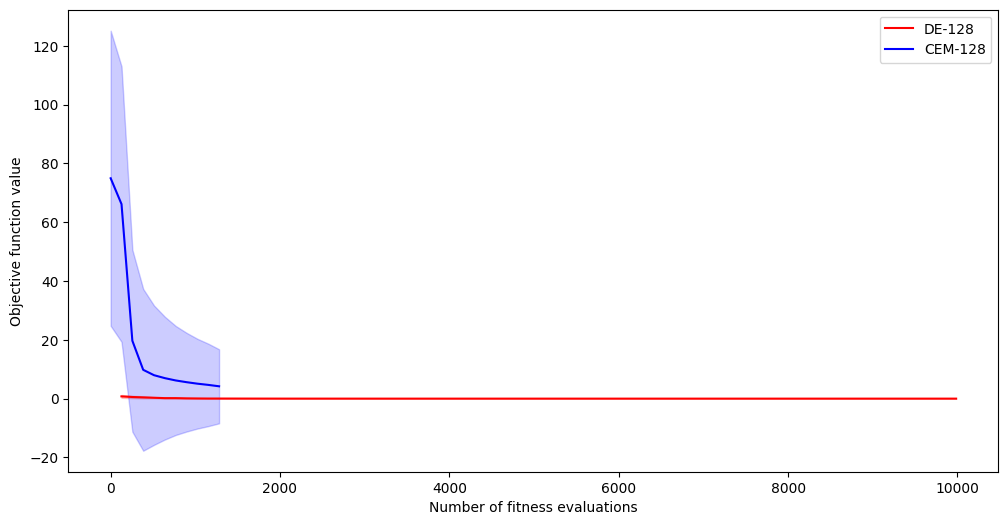

In [312]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### **dimensions (d=10)**

In [313]:
# DE, popsize = 128
all_results = []

dimension = 10
max_evals = 100000
fobj = Sphere
seed_number = 21521749
popsize = 128
lower_bound = -100
upper_bound = 100

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [314]:
# CEM, popsize = 128
dimension = 10
obj = Sphere
max_evals = 100000
seed_number = 21521749
lower_bound = -100
upper_bound = 100
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

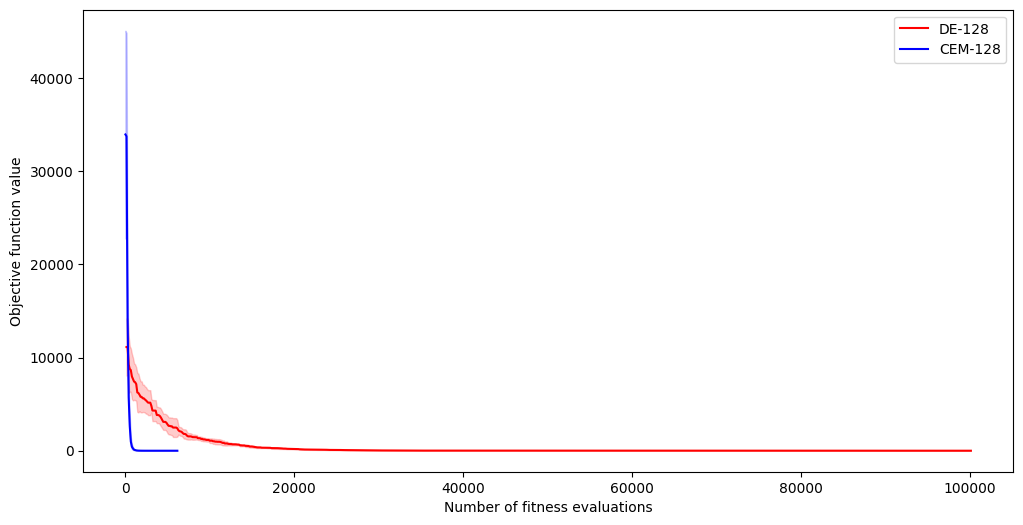

In [315]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

## **Hàm Michalewicz**

### **dimensions (d=2)**

In [316]:
# DE, popsize = 128
all_results = []

dimension = 2
max_evals = 20000
fobj = Michalewicz
seed_number = 21521749
popsize = 128
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [317]:
# CEM, popsize = 128
dimension = 2
obj = Michalewicz
max_evals = 20000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

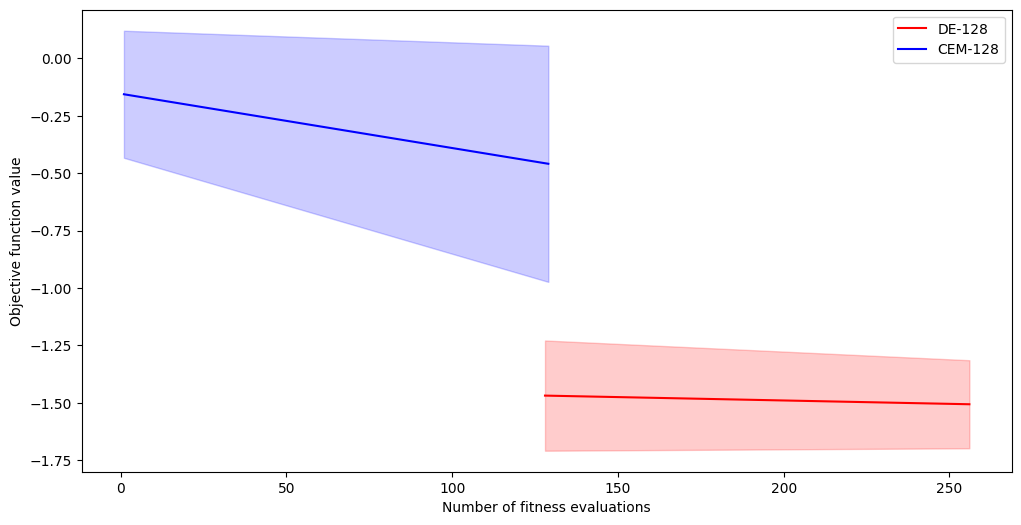

In [318]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])


plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### **dimensions (d=10)**

In [319]:
# DE, popsize = 128
all_results = []

dimension = 10
max_evals = 100000
fobj = Michalewicz
seed_number = 21521749
popsize = 128
lower_bound = 0
upper_bound = math.pi

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [320]:
# CEM, popsize = 128
dimension = 10
obj = Michalewicz
max_evals = 100000
seed_number = 21521749
lower_bound = 0
upper_bound = math.pi
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

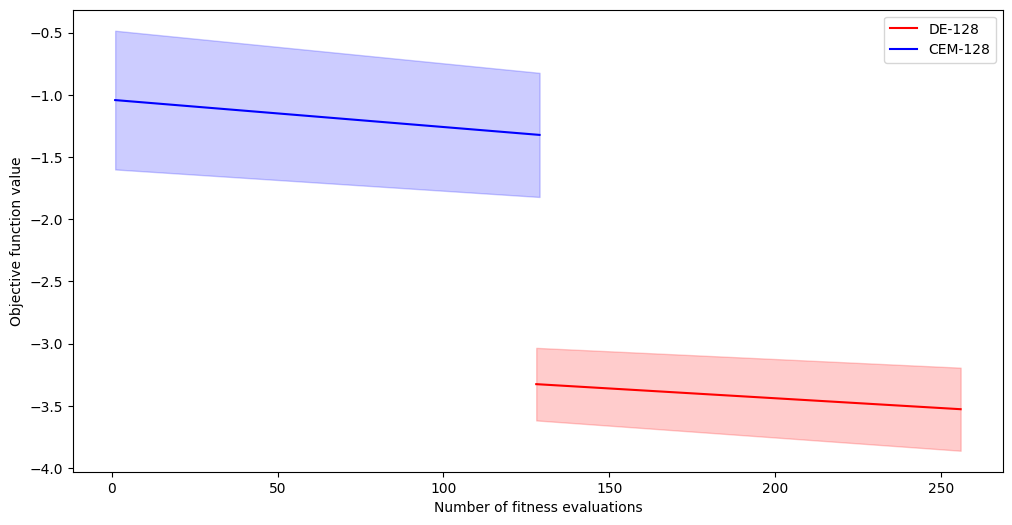

In [321]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

## **Hàm Rosenbrock**

### **dimensions (d=2)**

In [322]:
# DE, popsize = 128
all_results = []

dimension = 2
max_evals = 20000
fobj = Rosenbrock
seed_number = 21521749
popsize = 128
lower_bound = -2
upper_bound = 2

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [323]:
# CEM, popsize = 128
dimension = 2
obj = Rosenbrock
max_evals = 20000
seed_number = 21521749
lower_bound = -2
upper_bound = 2
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

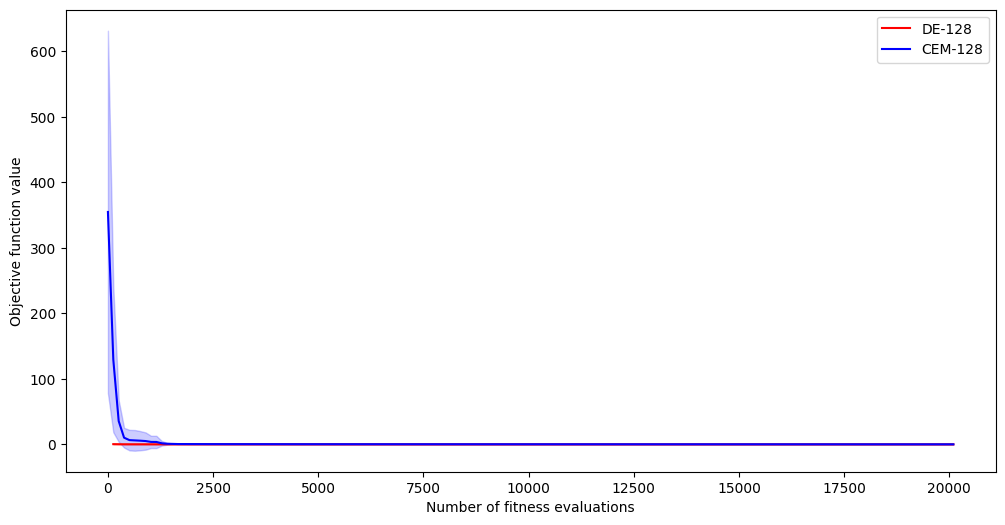

In [324]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### **dimensions (d=10)**

In [325]:
# DE, popsize = 128
all_results = []

dimension = 10
max_evals = 100000
fobj = Rosenbrock
seed_number = 21521749
popsize = 128
lower_bound = -5
upper_bound = 5

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [326]:
# CEM, popsize = 128
dimension = 10
obj = Rosenbrock
max_evals = 100000
seed_number = 21521749
lower_bound = -5
upper_bound = 5
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

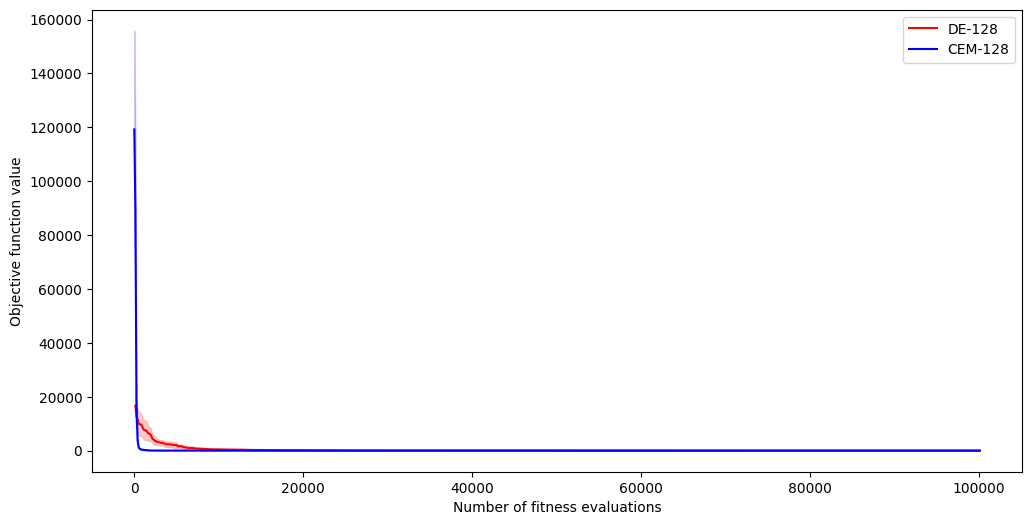

In [327]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

## **Hàm Griewank**

### **dimensions (d=2)**

In [328]:
# DE, popsize = 128
all_results = []

dimension = 2
max_evals = 20000
fobj = Griewank
seed_number = 21521749
popsize = 128
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [329]:
# CEM, popsize = 128
dimension = 2
obj = Griewank
max_evals = 20000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

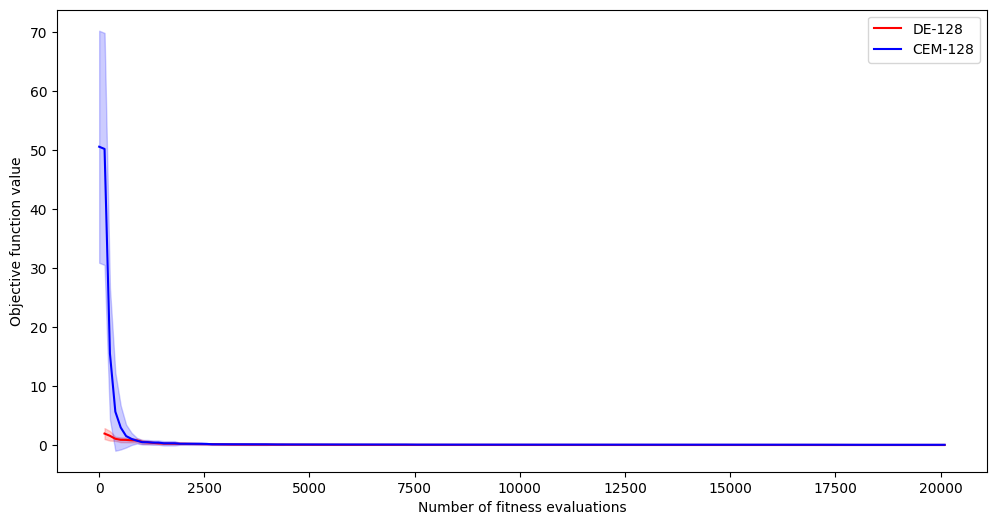

In [330]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### **dimensions (d=10)**

In [331]:
# DE, popsize = 128
all_results = []

dimension = 10
max_evals = 100000
fobj = Griewank
seed_number = 21521749
popsize = 128
lower_bound = -600
upper_bound = 600

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [332]:
# CEM, popsize = 128
dimension = 10
obj = Griewank
max_evals = 100000
seed_number = 21521749
lower_bound = -600
upper_bound = 600
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

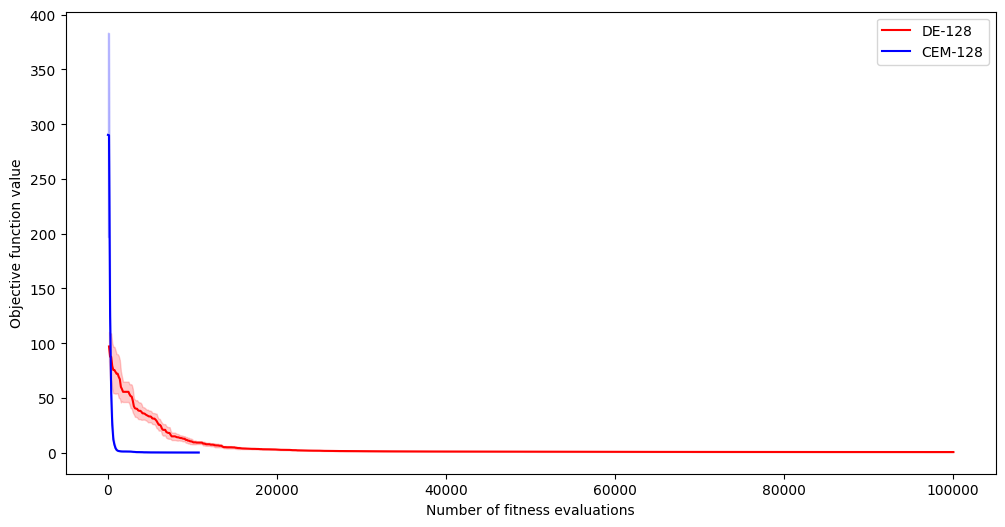

In [333]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

## **Hàm Ackley**

### **dimensions (d=2)**

In [334]:
# DE, popsize = 128
all_results = []

dimension = 2
max_evals = 20000
fobj = Ackley
seed_number = 21521749
popsize = 128
lower_bound = -32
upper_bound = 32

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [335]:
# CEM, popsize = 128
dimension = 2
obj = Ackley
max_evals = 20000
seed_number = 21521749
lower_bound = -32
upper_bound = 32
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

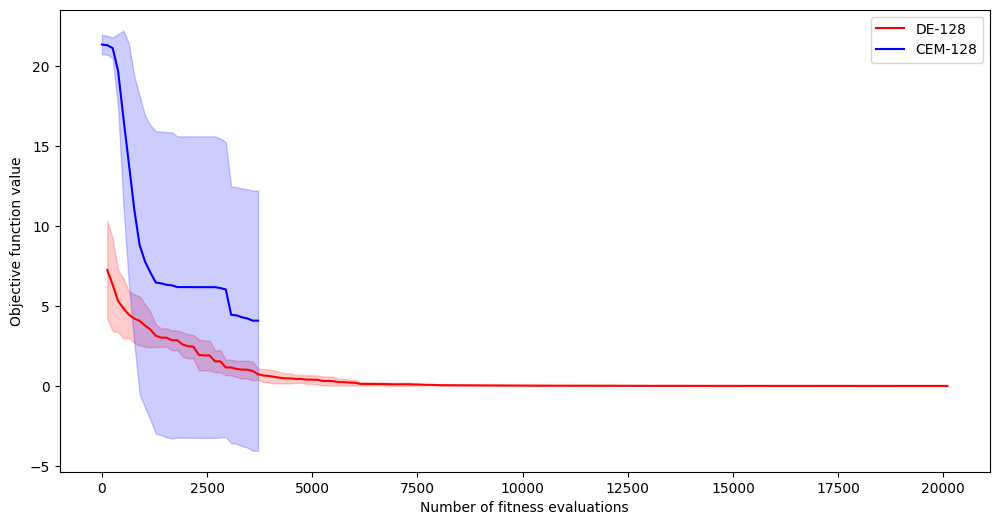

In [336]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

### **dimensions (d=10)**

In [337]:
# DE, popsize = 128
all_results = []

dimension = 10
max_evals = 100000
fobj = Ackley
seed_number = 21521749
popsize = 128
lower_bound = -50
upper_bound = 50

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_de_128 = []
plt_std_de_128 = []
plt_eval_de_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_de_128.append(np.mean(fitness))
    plt_std_de_128.append(np.std(fitness))
    plt_eval_de_128.append(np.mean(eval))

In [338]:
# CEM, popsize = 128
dimension = 10
obj = Ackley
max_evals = 100000
seed_number = 21521749
lower_bound = -50
upper_bound = 50
popsize = 128
bounds = [(lower_bound, upper_bound)]*dimension
np.random.rand(seed_number)
all_results = []

for i in range(10):
    np.random.rand(seed_number)
    results, all_pops, generation_count = CEM(fobj, bounds, sigma_init, elite_fraction, popsize, max_evals)
    all_results.append(results)
    seed_number += 1

plt_fitness_cem_128 = []
plt_std_cem_128 = []
plt_eval_cem_128 = []
for i in range(np.min([len(all_results[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_results[j][i][1])
        eval.append(all_results[j][i][2])
    plt_fitness_cem_128.append(np.mean(fitness))
    plt_std_cem_128.append(np.std(fitness))
    plt_eval_cem_128.append(np.mean(eval))

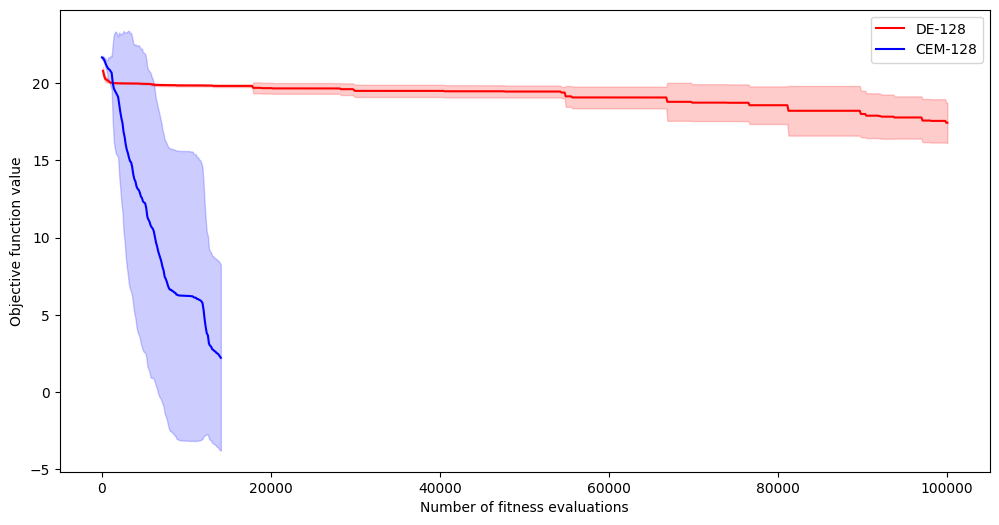

In [339]:
error1_de_128, error2_de_128 = [], []
for i in range(len(plt_fitness_de_128)):
    error1_de_128.append(plt_fitness_de_128[i] + plt_std_de_128[i])
    error2_de_128.append(plt_fitness_de_128[i] - plt_std_de_128[i])

error1_cem_128, error2_cem_128 = [], []
for i in range(len(plt_fitness_cem_128)):
    error1_cem_128.append(plt_fitness_cem_128[i] + plt_std_cem_128[i])
    error2_cem_128.append(plt_fitness_cem_128[i] - plt_std_cem_128[i])

plt.figure(figsize=(12, 6))

# DE
plt.plot(plt_eval_de_128, plt_fitness_de_128, label='DE-128', color='red')
plt.fill_between(plt_eval_de_128, error1_de_128, error2_de_128, color='red', alpha=0.2)

# CEM
plt.plot(plt_eval_cem_128, plt_fitness_cem_128, label='CEM-128', color='blue')
plt.fill_between(plt_eval_cem_128, error1_cem_128, error2_cem_128, color='blue', alpha=0.2)

plt.xlabel('Number of fitness evaluations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

# Gif

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Sphere - DE - d = 2 - n = 32


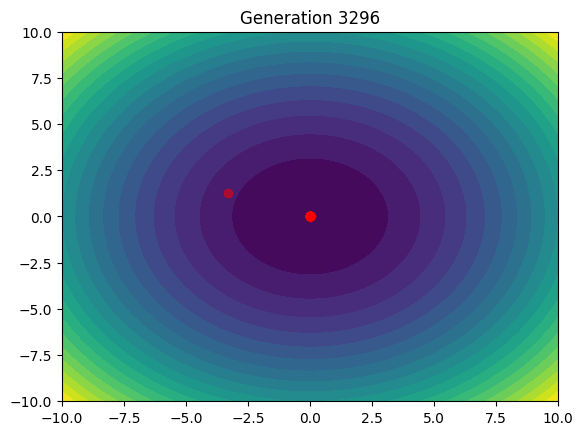

In [341]:
seed_number = 21521749

def run_DE(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = DE(Sphere, 2, [(-10, 10)] * 2, F_scale, cross_prob, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_DE(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('DE_sphere_animation.gif', writer='imagemagick')

plt.show()

## Michalewicz - DE - d = 2 - n = 32

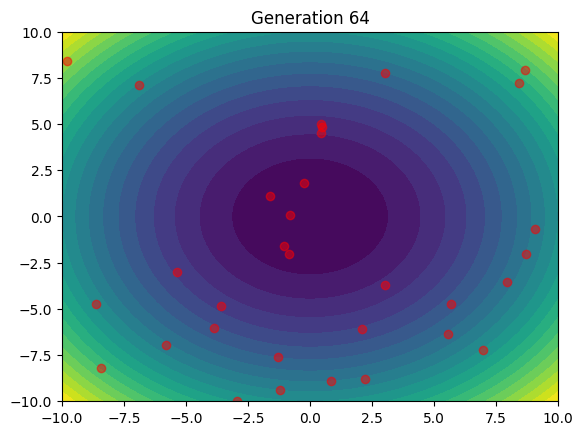

In [342]:
seed_number = 21521749

def run_DE(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = DE(Michalewicz, 2, [(-10, 10)] * 2, F_scale, cross_prob, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_DE(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('DE_michalewicz_animation.gif', writer='imagemagick')

plt.show()

## Rosenbrock - DE - d = 2 - n = 32

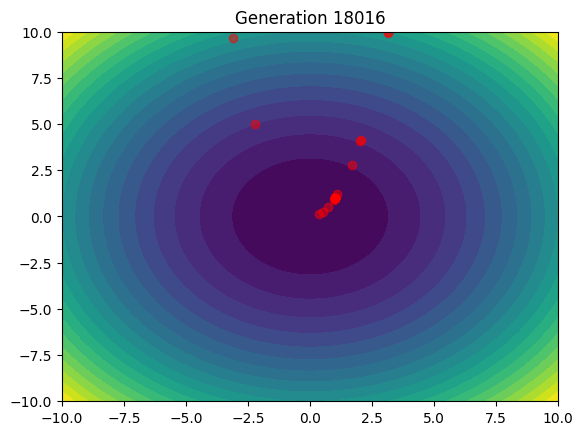

In [343]:
seed_number = 21521749

def run_DE(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = DE(Rosenbrock, 2, [(-10, 10)] * 2, F_scale, cross_prob, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_DE(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('DE_rosenbrock_animation.gif', writer='imagemagick')

plt.show()

## Griewank - DE - d = 2 - n = 32

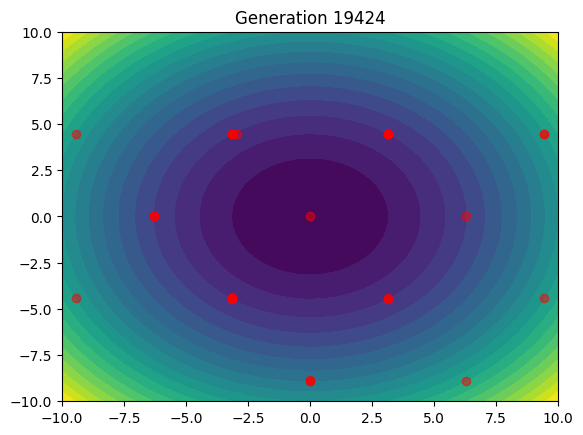

In [344]:
seed_number = 21521749

def run_DE(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = DE(Griewank, 2, [(-10, 10)] * 2, F_scale, cross_prob, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_DE(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('DE_griewank_animation.gif', writer='imagemagick')

plt.show()

## Ackley - DE - d = 2 - n = 32

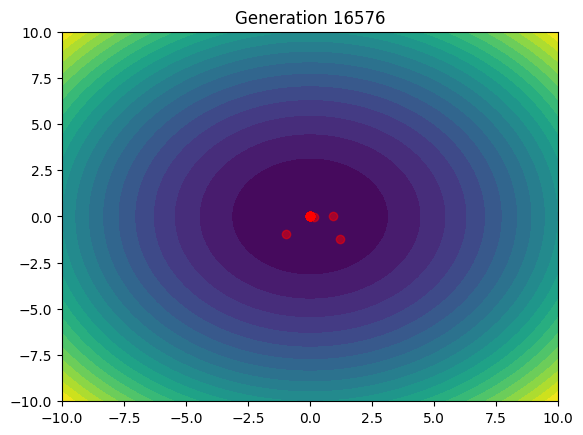

In [345]:
seed_number = 21521749

def run_DE(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = DE(Ackley, 2, [(-10, 10)] * 2, F_scale, cross_prob, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_DE(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('DE_ackley_animation.gif', writer='imagemagick')

plt.show()

## Sphere - CEM - d = 2 - n = 32

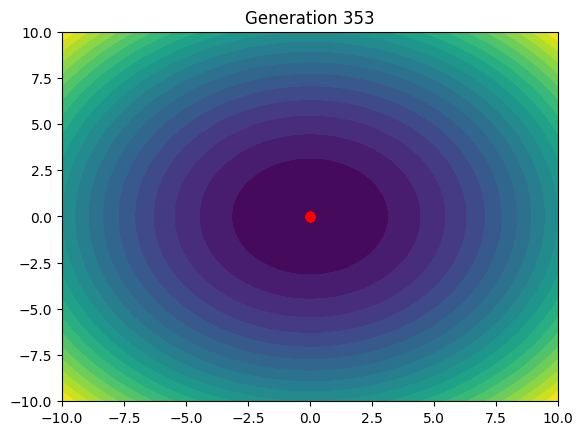

In [346]:
seed_number = 21521749

def run_CEM(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = CEM(Sphere, [(-10, 10)] * 2, sigma_init, elite_fraction, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_CEM(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('CEM_sphere_animation.gif', writer='imagemagick')

plt.show()

## Michalewicz - CEM - d = 2 - n = 32

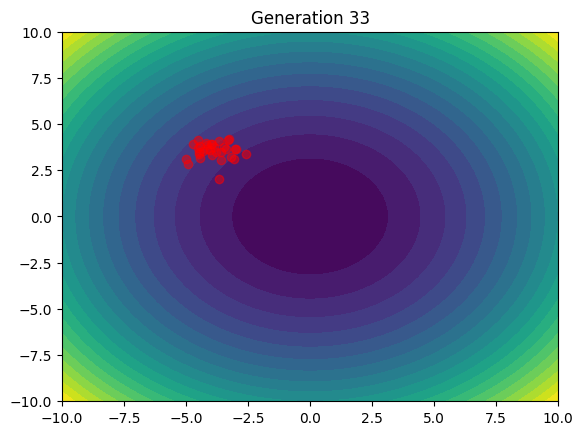

In [347]:
seed_number = 21521749

def run_CEM(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = CEM(Michalewicz, [(-10, 10)] * 2, sigma_init, elite_fraction, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_CEM(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('CEM_michalewicz_animation.gif', writer='imagemagick')

plt.show()

## Rosenbrock - CEM - d = 2 - n = 32

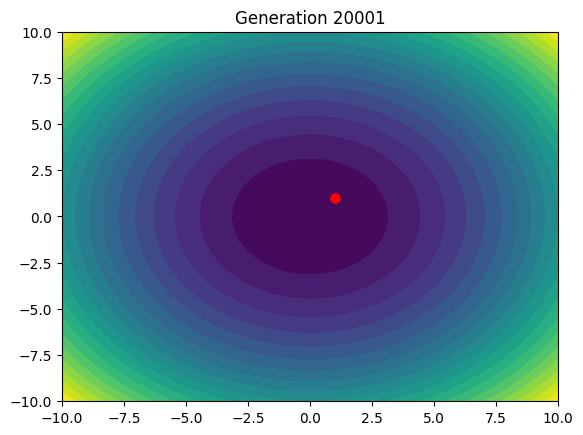

In [348]:
seed_number = 21521749

def run_CEM(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = CEM(Rosenbrock, [(-10, 10)] * 2, sigma_init, elite_fraction, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_CEM(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('CEM_rosenbrock_animation.gif', writer='imagemagick')

plt.show()

## Griewank - CEM - d = 2 - n = 32

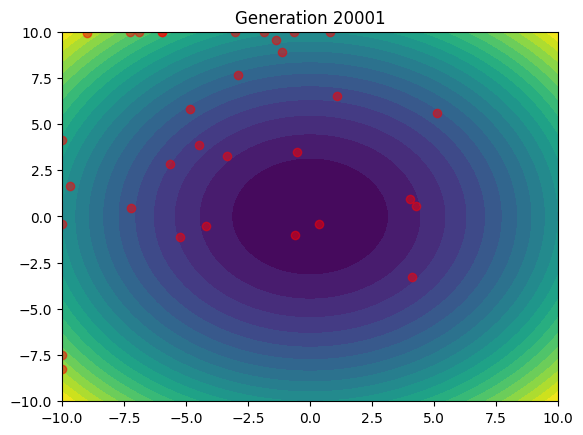

In [349]:
seed_number = 21521749

def run_CEM(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = CEM(Griewank, [(-10, 10)] * 2, sigma_init, elite_fraction, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_CEM(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('CEM_griewank_animation.gif', writer='imagemagick')

plt.show()

## Ackley - CEM - d = 2 - n = 32

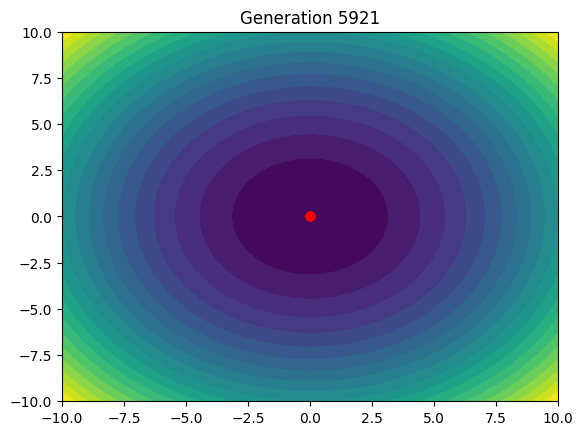

In [350]:
seed_number = 21521749

def run_CEM(seed_number):
    np.random.seed(seed_number)
    results, all_pops, generation_count = CEM(Ackley, [(-10, 10)] * 2, sigma_init, elite_fraction, 32, 20000)
    return all_pops, generation_count

fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


def update(frame):
    ax.clear()
    all_pops, generation_count = run_CEM(seed_number + frame)
    population = all_pops[-1]
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = Sphere(np.array([X, Y]))
    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(population[:, 0], population[:, 1], color='red', alpha=0.5)
    ax.set_title(f'Generation {generation_count}')

ani = FuncAnimation(fig, update, frames=100, interval=500)
ani.save('CEM_ackley_animation.gif', writer='imagemagick')

plt.show()